In [11]:
import signac
import matplotlib.pyplot as plt
import numpy as np
import gsd.hoomd

from cmeutils.structure import (
    bond_distribution,
    angle_distribution,
    dihedral_distribution,
    gsd_rdf,
    persistence_length
)

from cmeutils.plotting import get_histogram
from msibi.utils.smoothing import savitzky_golay
from msibi.potentials import linear_head_correction
from polybinderCG.coarse_grain import System
from utils import radius_of_gyration, end_to_end

In [12]:
# Matplotlib RC Params:    
color_dict = {1.0: "#0F0E0F", 0.8: "#666666", 0.7: "#964d4d", 0.6: "#d03f3f"}
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 7
plt.rcParams['lines.markersize'] = 2
plt.rcParams["lines.linestyle"] = "-"
plt.rcParams["lines.marker"] = "o"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.dpi"] = 1200

# Bulk System comparison:

In [13]:
project = signac.get_project("../coarse-grain-sims/test-ekk-hypoth/bulk-sims/polybinder-flow/")

In [14]:
density = 1.27
temp = 5.0

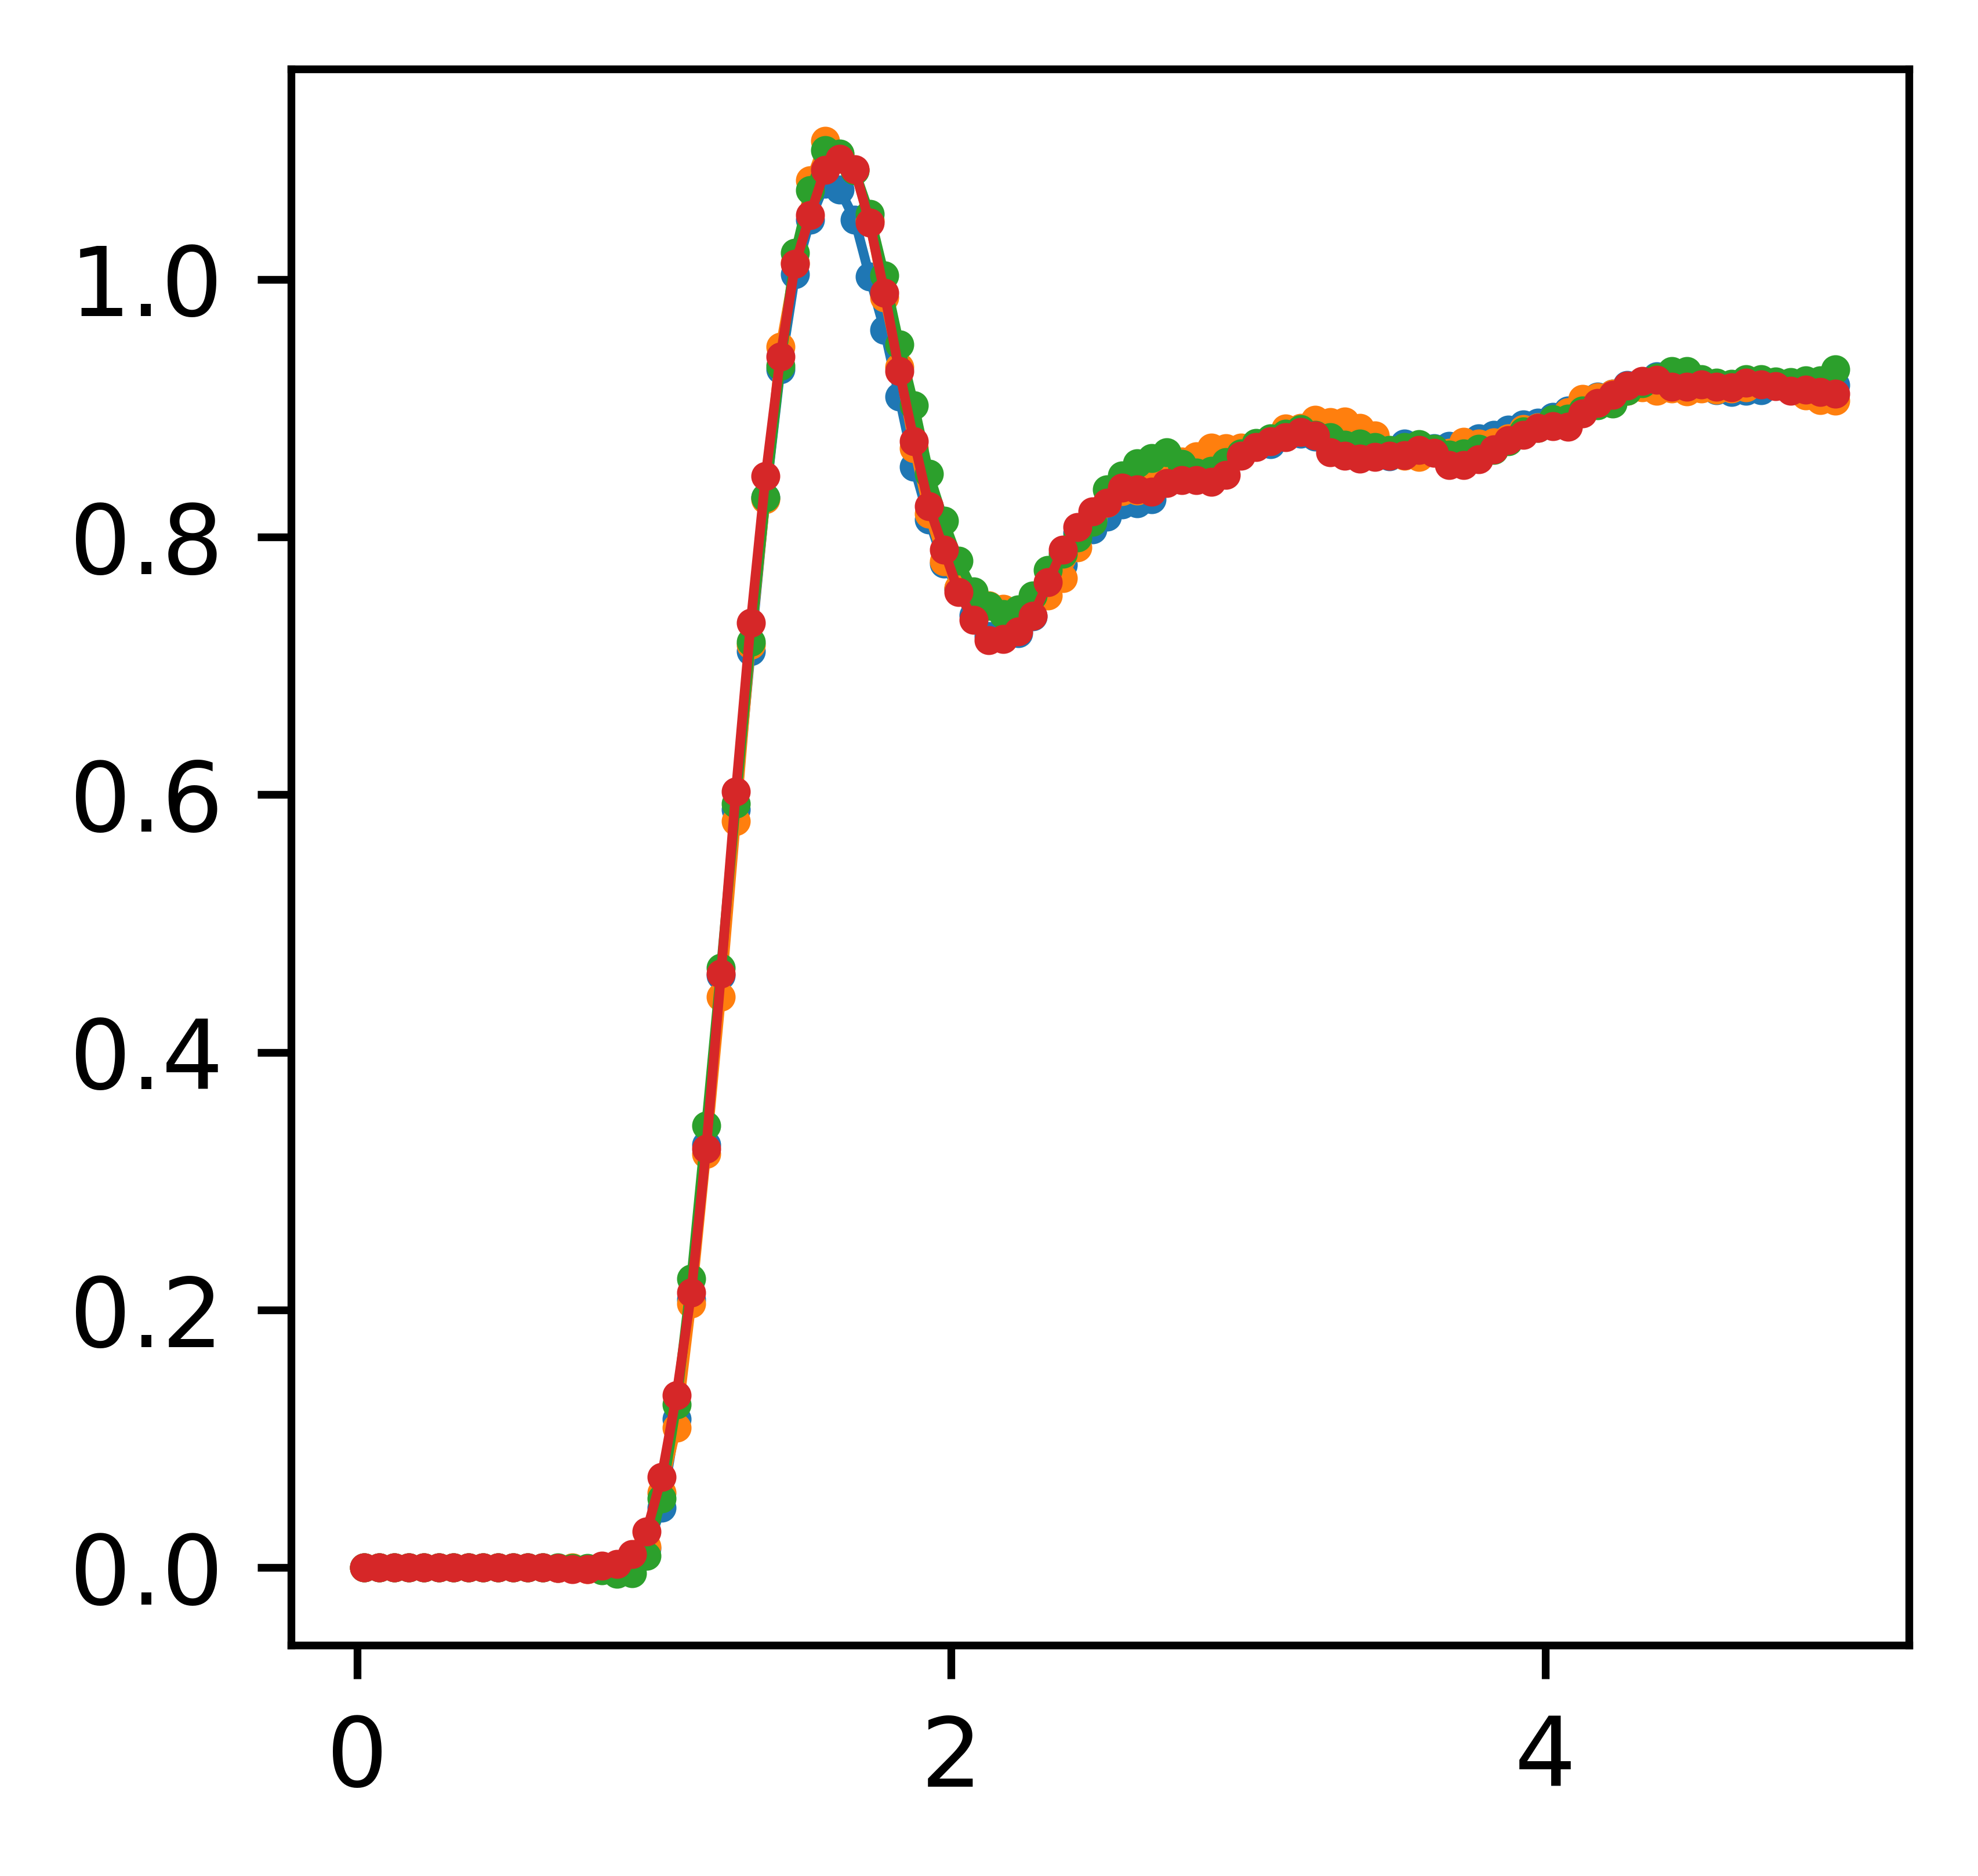

In [15]:
test_weights = []
test_rdfs = []
test_rdf_ranges = []
test_temps = []

for weight, job in project.find_jobs(
    {"density": density, "kT_quench": temp}, doc_filter={"kek_angle": "constant"}
).groupby("ekk_weight"):
    job = list(job)[0]
    rdf, N = gsd_rdf(
        gsdfile=job.fn("sim_traj.gsd"),
        A_name="E",
        B_name="E",
        start=-50,
        stop=-1,
        r_max=5,
        exclude_bonded=True,
    )
    #plt.plot(rdf.bin_centers, rdf.rdf * N, label=job.sp.ekk_weight)
    smoothed = savitzky_golay(rdf.rdf*N, window_size=9, order=2)
    plt.plot(rdf.bin_centers, smoothed)
    test_weights.append(weight)
    test_rdfs.append(smoothed)
    test_rdf_ranges.append(rdf.bin_centers)

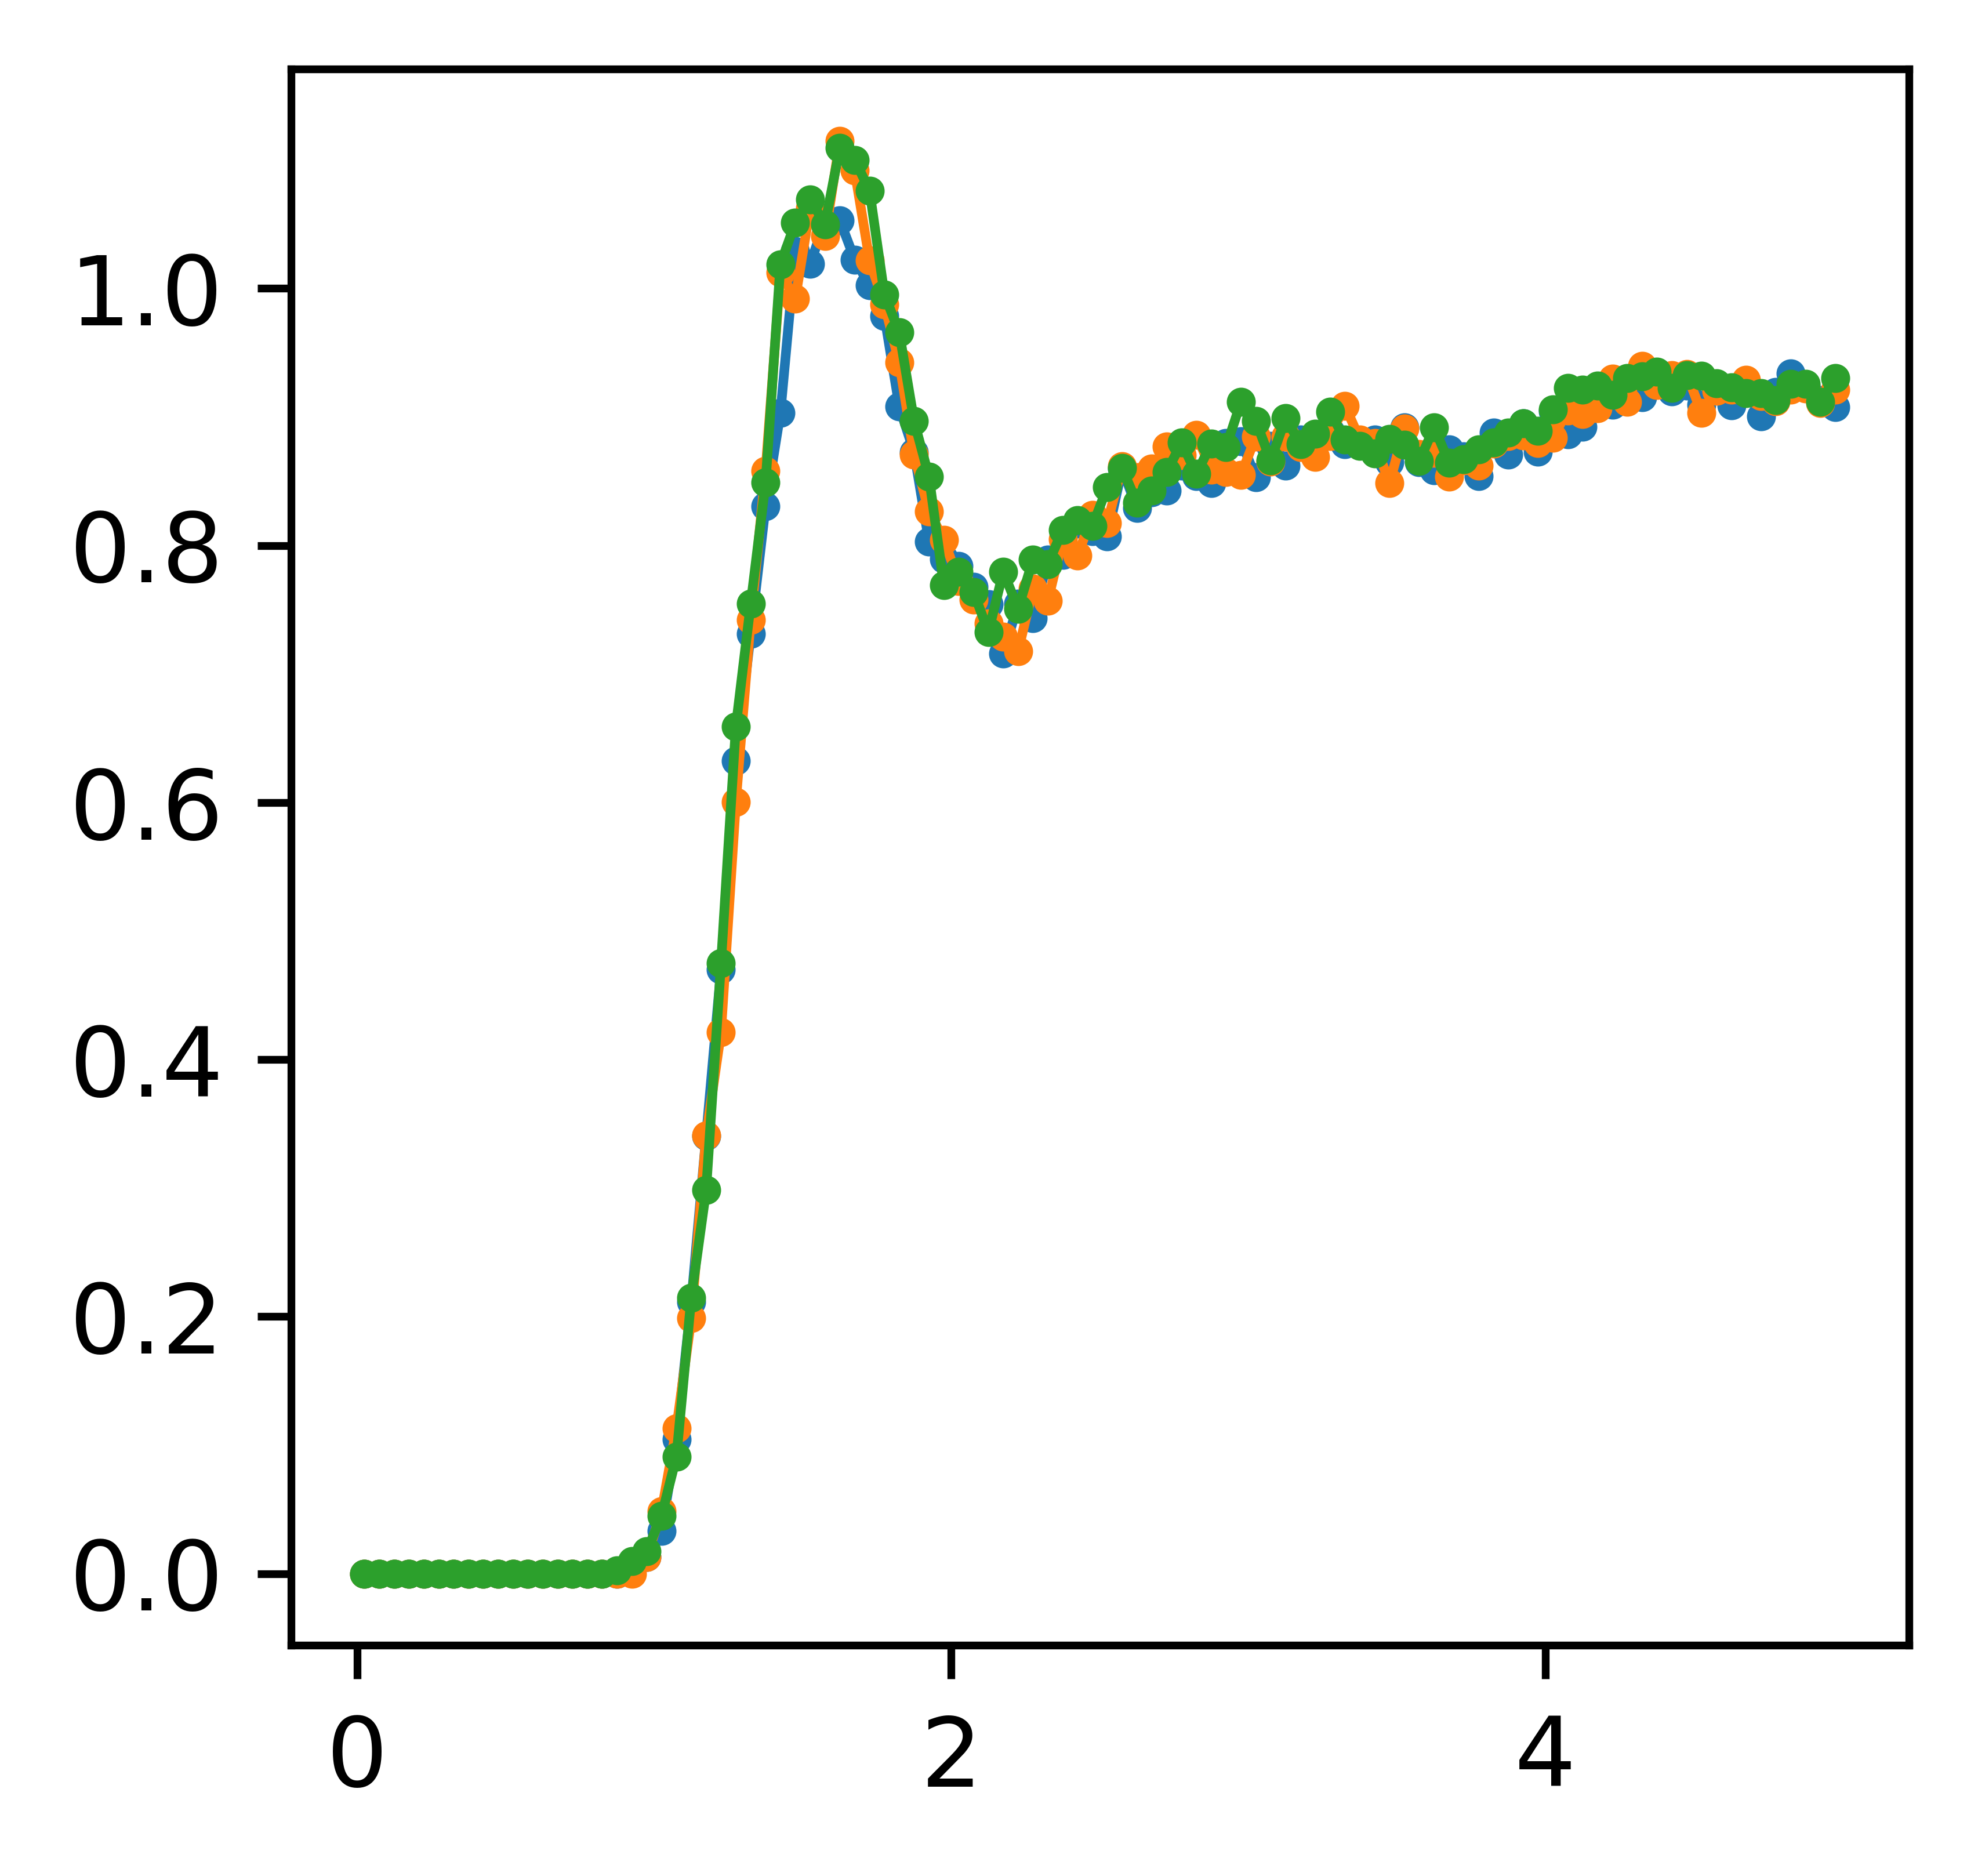

In [16]:
control_weights = []
control_rdfs = []
control_rdf_ranges = []
control_temps = []

for weight, job in project.find_jobs(
    {"density": density, "kT_quench": temp}, doc_filter={"kek_angle": "varies"}
).groupby("ekk_weight"):
    job = list(job)[0]
    assert job.sp.ekk_weight == job.sp.kek_weight
    rdf, N = gsd_rdf(
        gsdfile=job.fn("sim_traj.gsd"),
        A_name="E",
        B_name="E",
        start=-50,
        stop=-1,
        r_max=5,
        exclude_bonded=True,
    )
    plt.plot(rdf.bin_centers, rdf.rdf * N, label=job.sp.ekk_weight)
    smoothed = savitzky_golay(rdf.rdf*N, window_size=9, order=2)
    control_weights.append(weight)
    control_rdfs.append(smoothed)
    control_rdf_ranges.append(rdf.bin_centers)

In [7]:
control_weights

[0.6, 0.7, 0.8]

In [8]:
test_weights

[0.6, 0.7, 0.8, 1.0]

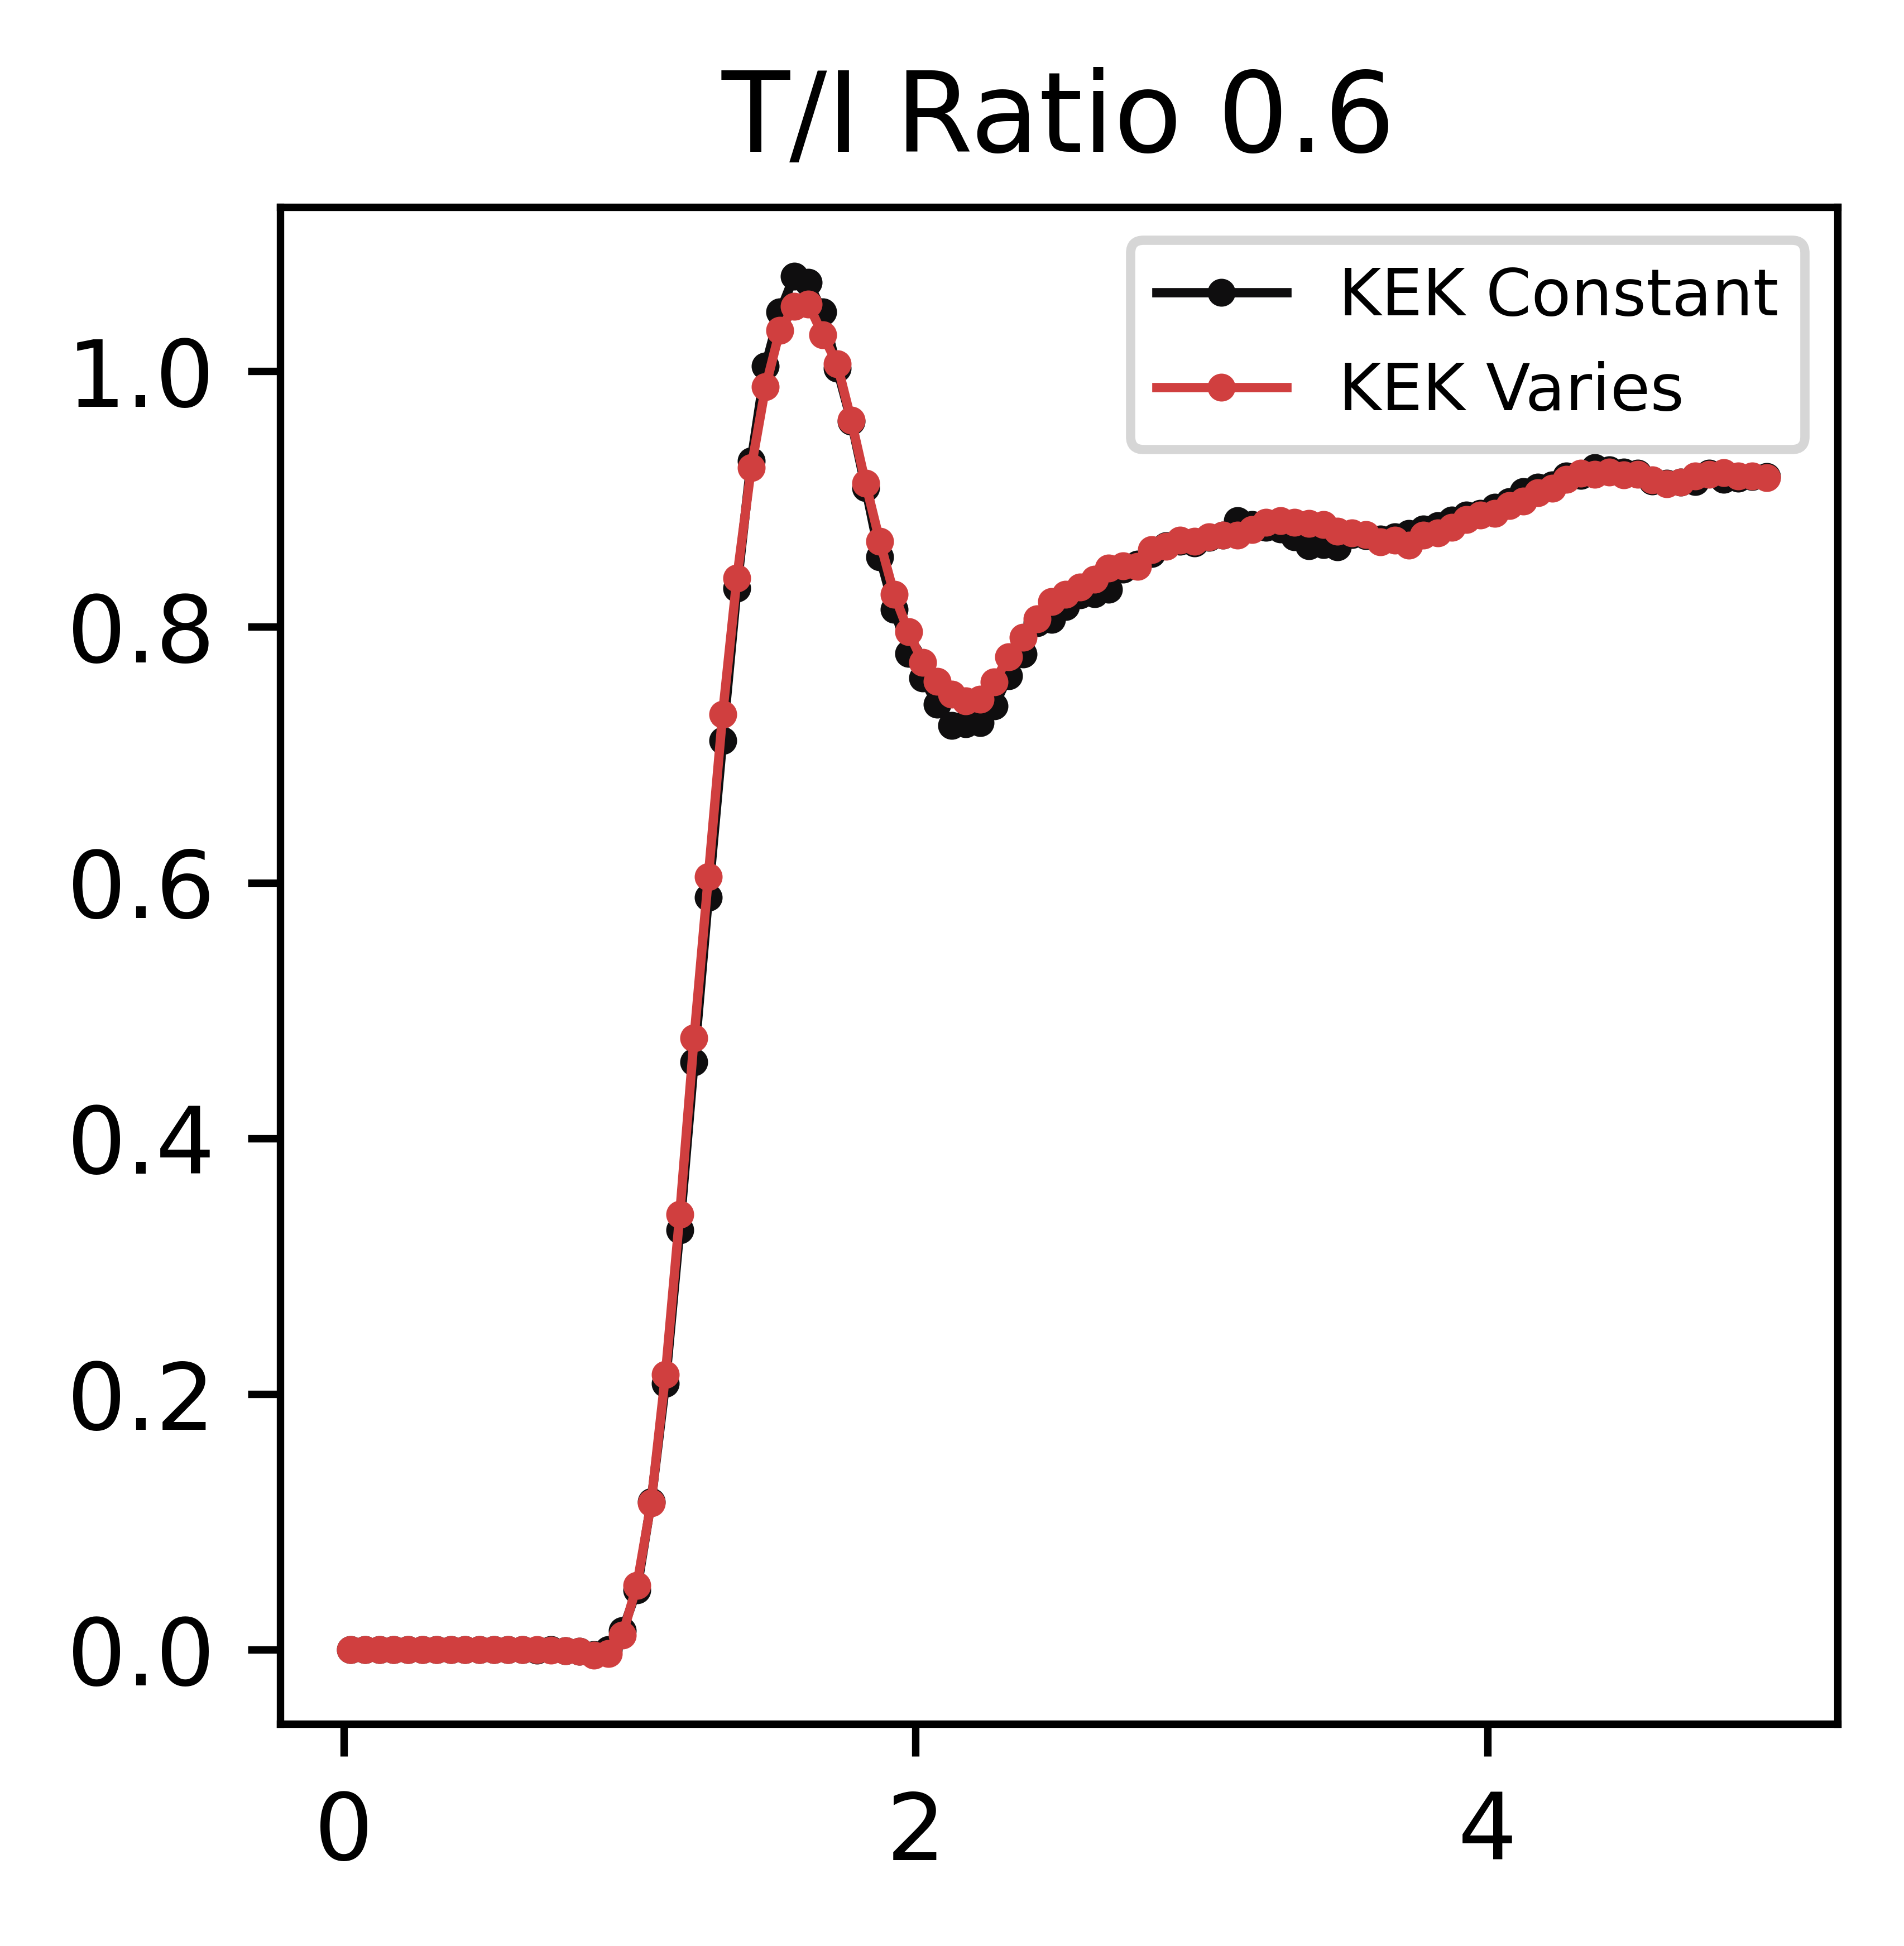

In [17]:
index = 0
fig = plt.figure()
assert control_weights[index] == test_weights[index]
plt.plot(test_rdf_ranges[index], test_rdfs[index], label="KEK Constant", c="#0F0E0F")
plt.plot(control_rdf_ranges[index], control_rdfs[index], label="KEK Varies", c="#d03f3f")
plt.title(f"T/I Ratio {test_weights[index]}")
plt.legend()

# Chain statistics: Bulk system

In [84]:
n_frames = 20
lp_window_size = 5
#temp = 5.0

In [89]:
test_temps = []
test_weights = []

test_lp_results = []
test_lp_std = []
test_rg_results = []
test_rg_std = []
test_re_results = []
test_re_std = []

for weight, job in project.find_jobs(
    {"density": density, "kT_quench": temp}, doc_filter={"kek_angle": "constant"}
).groupby("ekk_weight"):
    if weight == 1.0:
        continue
    job = list(job)[0]
    test_weights.append(job.sp.ekk_weight)
    with gsd.hoomd.open(job.fn("sim_traj.gsd"), "rb") as traj:
        lp_stop = len(traj)
        lp_start = lp_stop - n_frames

    lp, lp_std = persistence_length(
        gsd_file=job.fn("sim_traj.gsd"),
        start=lp_start,
        stop=lp_stop,
        window_size=lp_window_size,
        select_atoms_arg="name E K"
    )
    test_lp_results.append(lp)
    test_lp_std.append(lp_std)

    # Radius of Gyration:
    rg = radius_of_gyration(job.fn("sim_traj.gsd"), n_frames=n_frames)
    test_rg_results.append(np.mean(rg))
    test_rg_std.append(np.std(rg))

    # End-to-End Distance:
    re = end_to_end(job.fn("sim_traj.gsd"), n_frames=n_frames)
    test_re_results.append(np.mean(re))
    test_re_std.append(np.std(re))

/home/chris/miniconda3/envs/msibi/lib/python3.9/site-packages/MDAnalysis/analysis/base.py:438: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time


In [90]:
test_weights

[0.6, 0.7, 0.8]

In [91]:
control_temps = []
control_weights = []

control_lp_results = []
control_lp_std = []
control_rg_results = []
control_rg_std = []
control_re_results = []
control_re_std = []

for weight, job in project.find_jobs(
    {"density": density, "kT_quench": temp}, doc_filter={"kek_angle": "varies"}
).groupby("ekk_weight"):
    job = list(job)[0]
    control_weights.append(job.sp.ekk_weight)
    with gsd.hoomd.open(job.fn("sim_traj.gsd"), "rb") as traj:
        lp_stop = len(traj)
        lp_start = lp_stop - n_frames

    lp, lp_std = persistence_length(
        gsd_file=job.fn("sim_traj.gsd"),
        start=lp_start,
        stop=lp_stop,
        window_size=lp_window_size,
        select_atoms_arg="name E K"
    )
    control_lp_results.append(lp)
    control_lp_std.append(lp_std)

    # Radius of Gyration:
    rg = radius_of_gyration(job.fn("sim_traj.gsd"), n_frames=n_frames)
    control_rg_results.append(np.mean(rg))
    control_rg_std.append(np.std(rg))

    # End-to-End Distance:
    re = end_to_end(job.fn("sim_traj.gsd"), n_frames=n_frames)
    control_re_results.append(np.mean(re))
    control_re_std.append(np.std(re))

In [92]:
control_weights

[0.6, 0.7, 0.8]

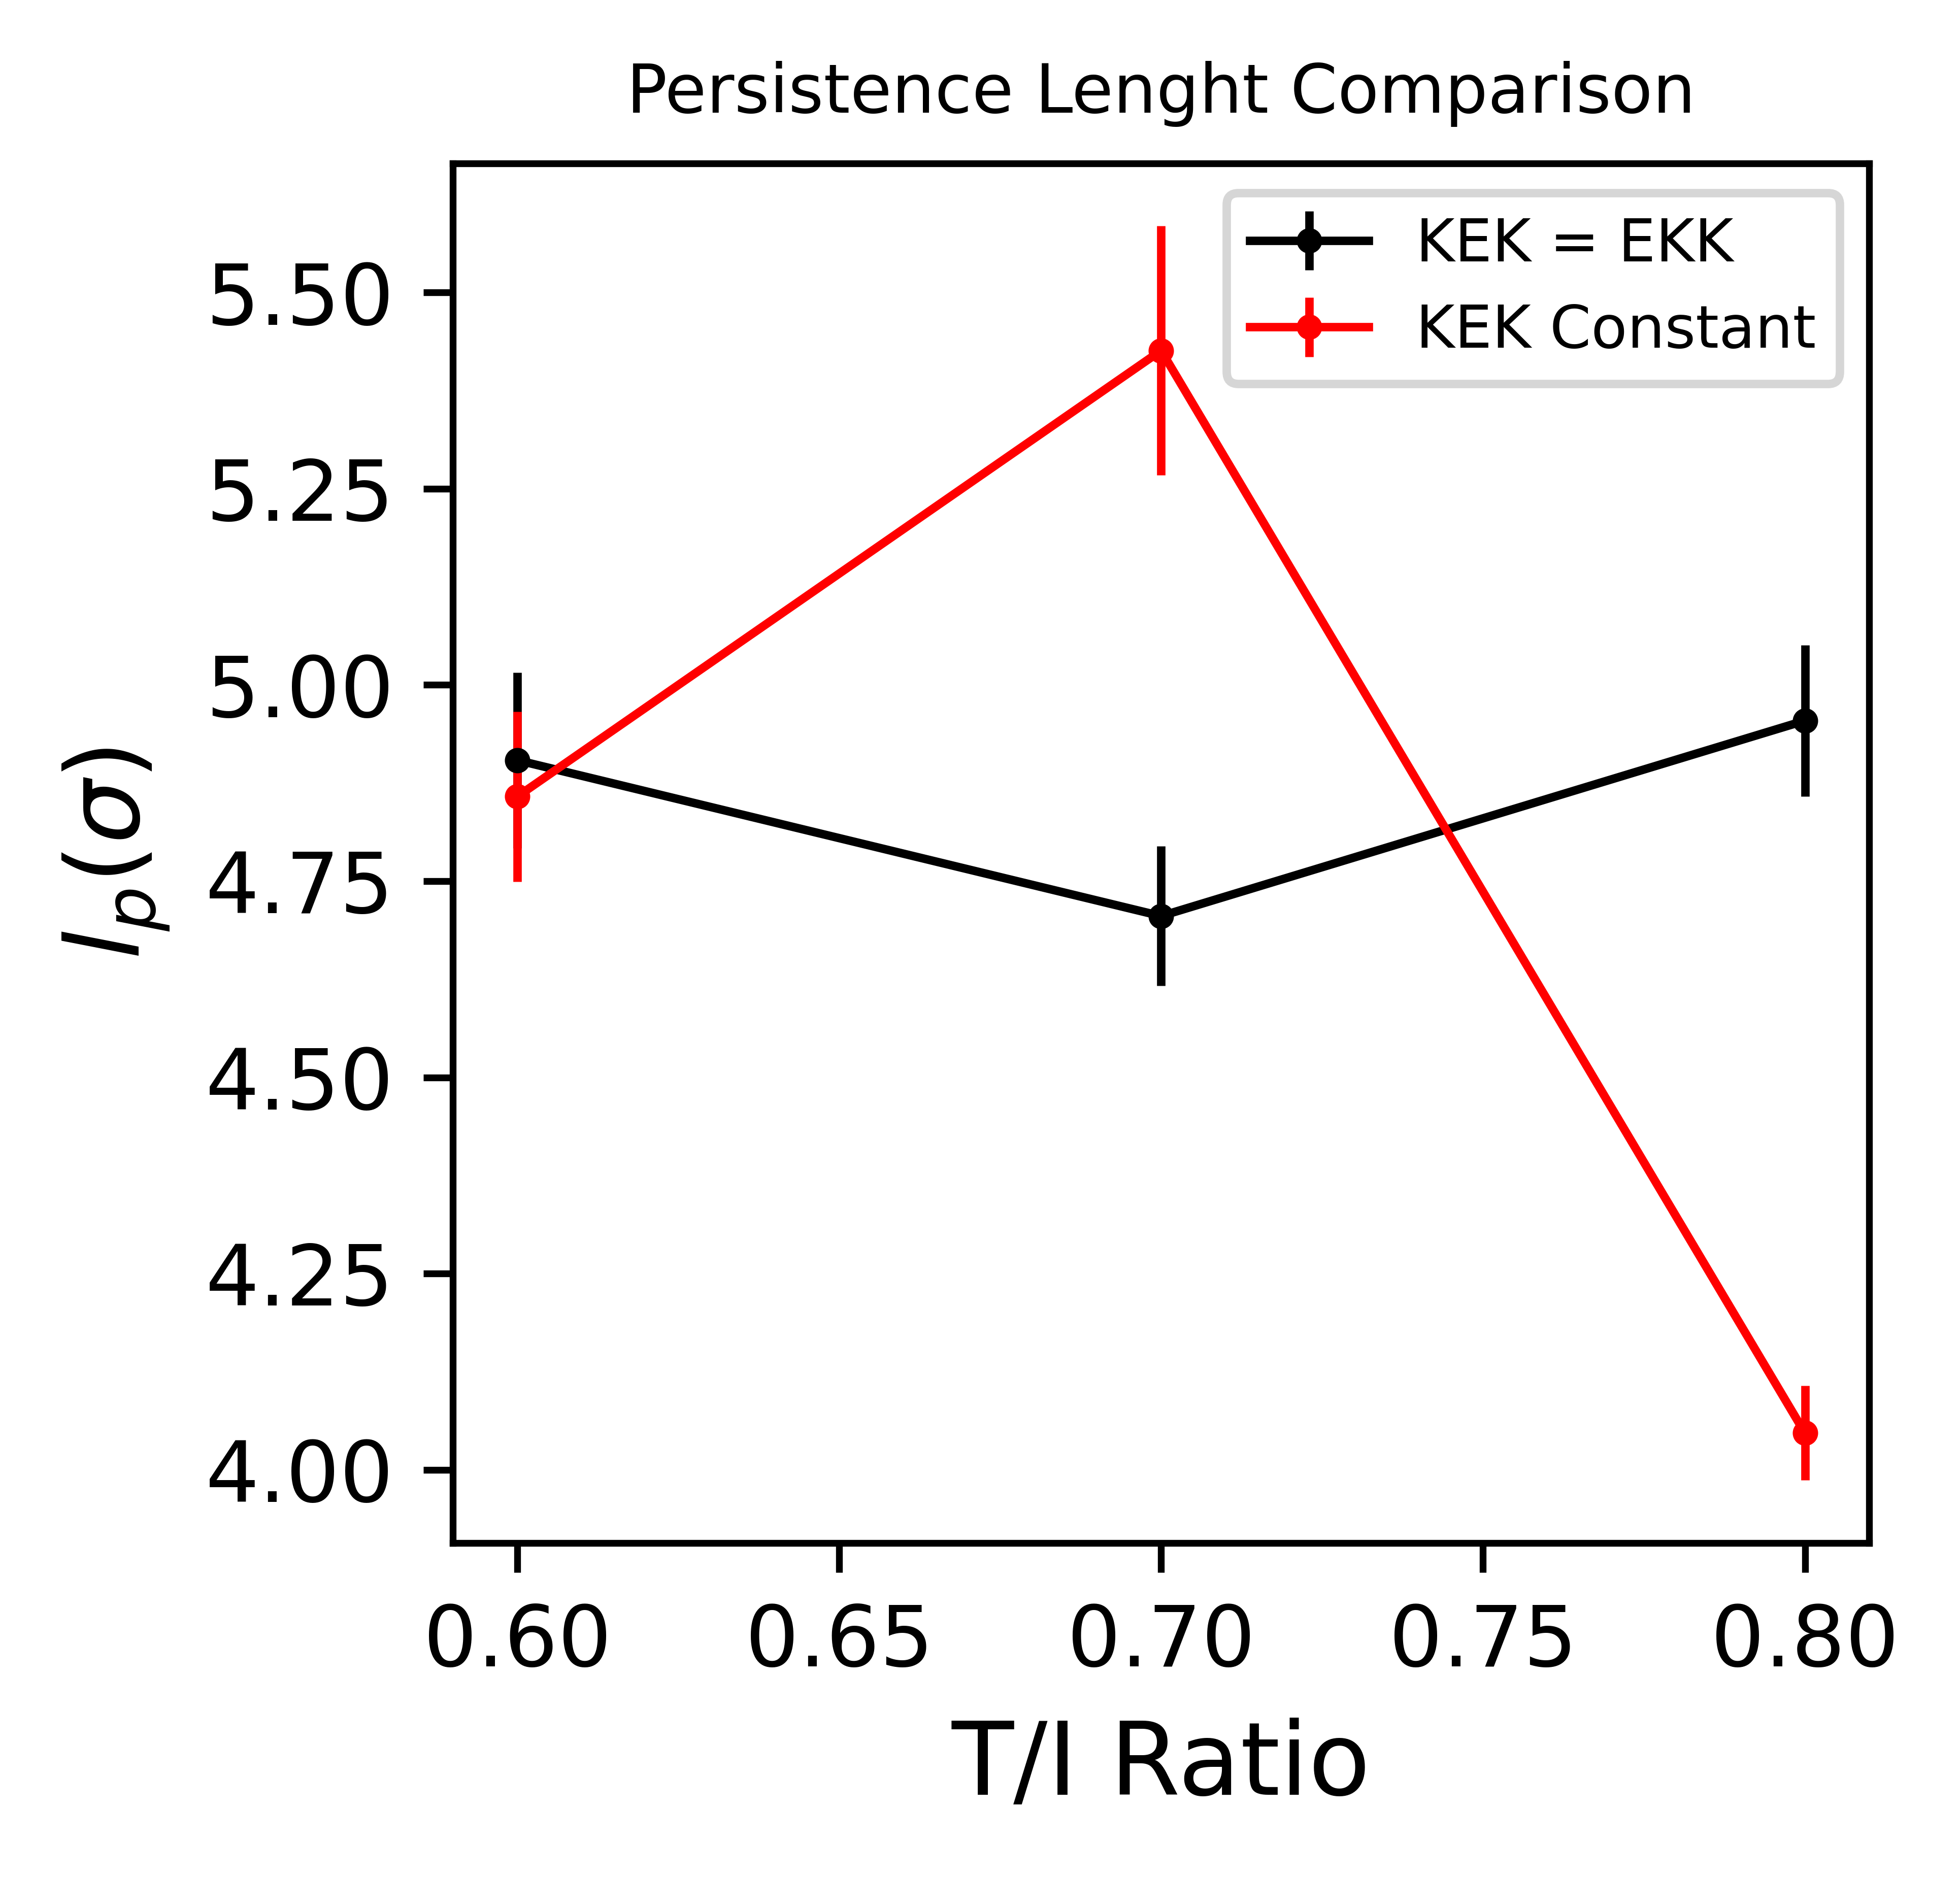

In [93]:
fig = plt.figure()
plt.errorbar(x=control_weights, y=control_lp_results, yerr=control_lp_std, label="KEK = EKK", c="k")
plt.errorbar(x=test_weights, y=test_lp_results, yerr=test_lp_std, label="KEK Constant", c="r")
plt.legend()
plt.title("Persistence Lenght Comparison", fontsize=8)
plt.xlabel("T/I Ratio")
plt.ylabel("$l_p (\sigma)$")
plt.show()

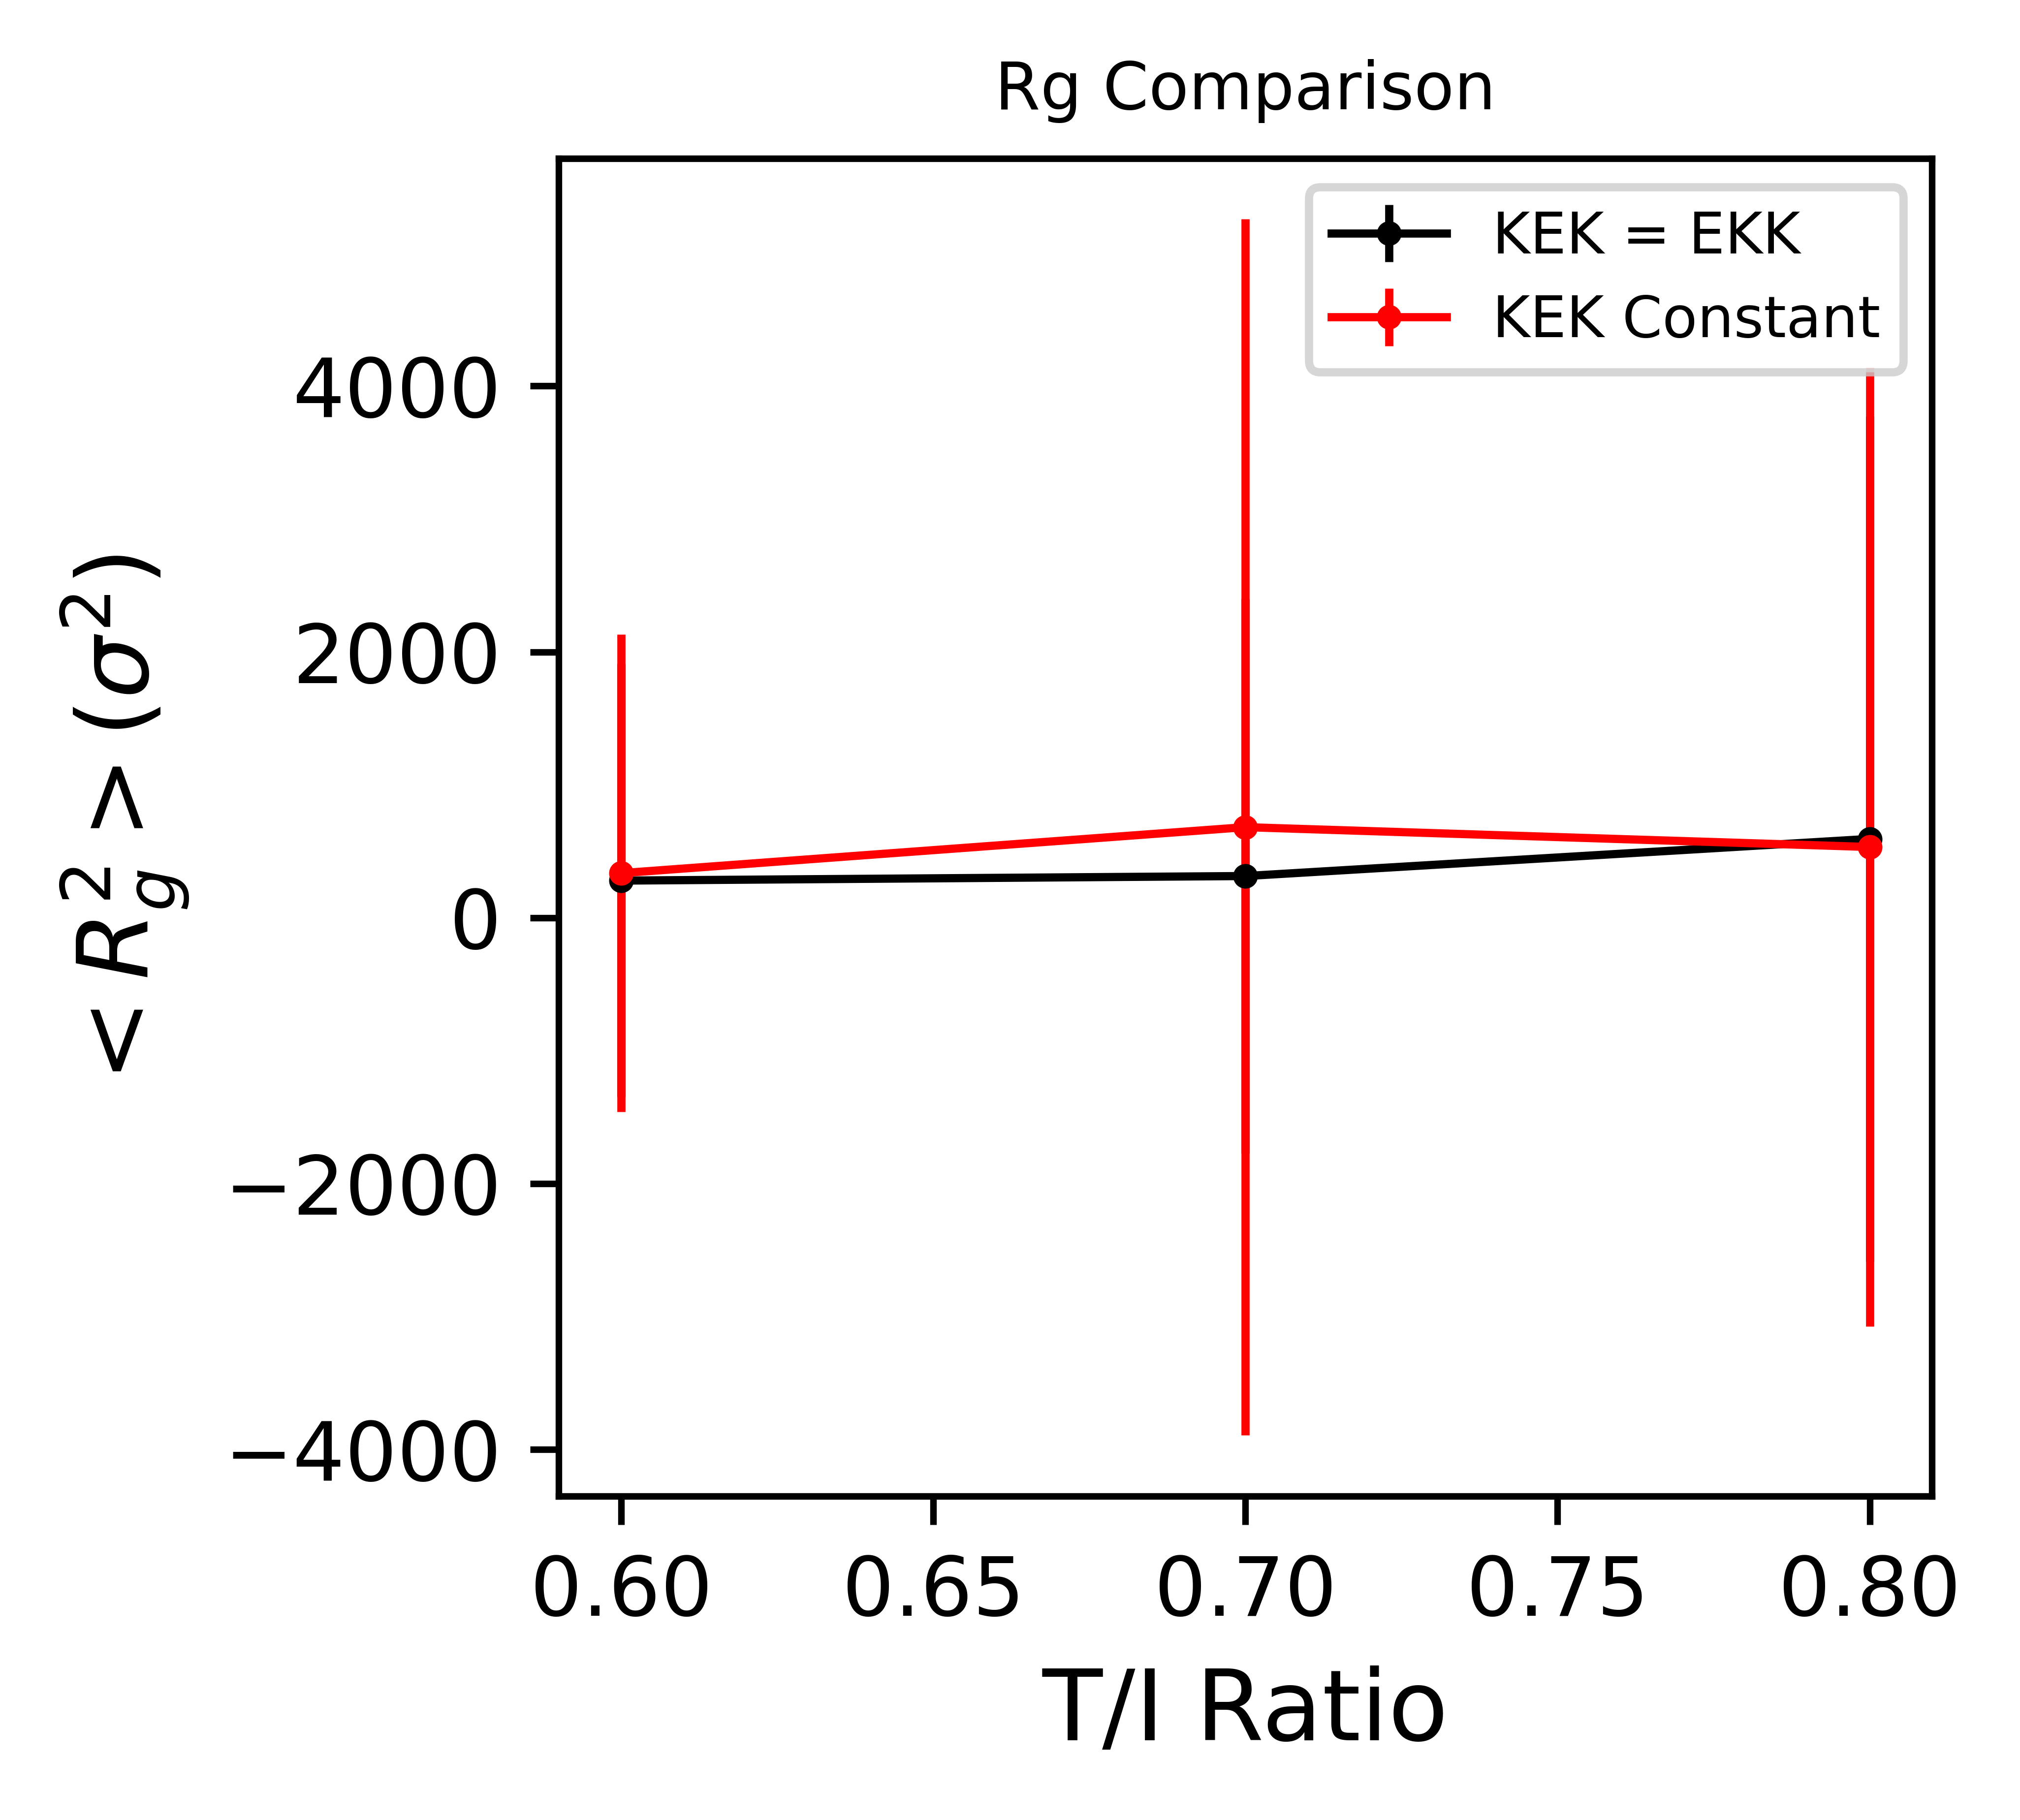

In [94]:
fig = plt.figure()
plt.errorbar(x=control_weights, y=control_rg_results, yerr=control_rg_std, label="KEK = EKK", c="k")
plt.errorbar(x=control_weights, y=test_rg_results, yerr=test_rg_std, label="KEK Constant", c="r")
plt.xlabel("T/I Ratio")
plt.ylabel("$<R_g^2> (\sigma^2)$")
plt.title(f"Rg Comparison", fontsize=8)
plt.legend()

TypeError: plot got an unexpected keyword argument 'x'

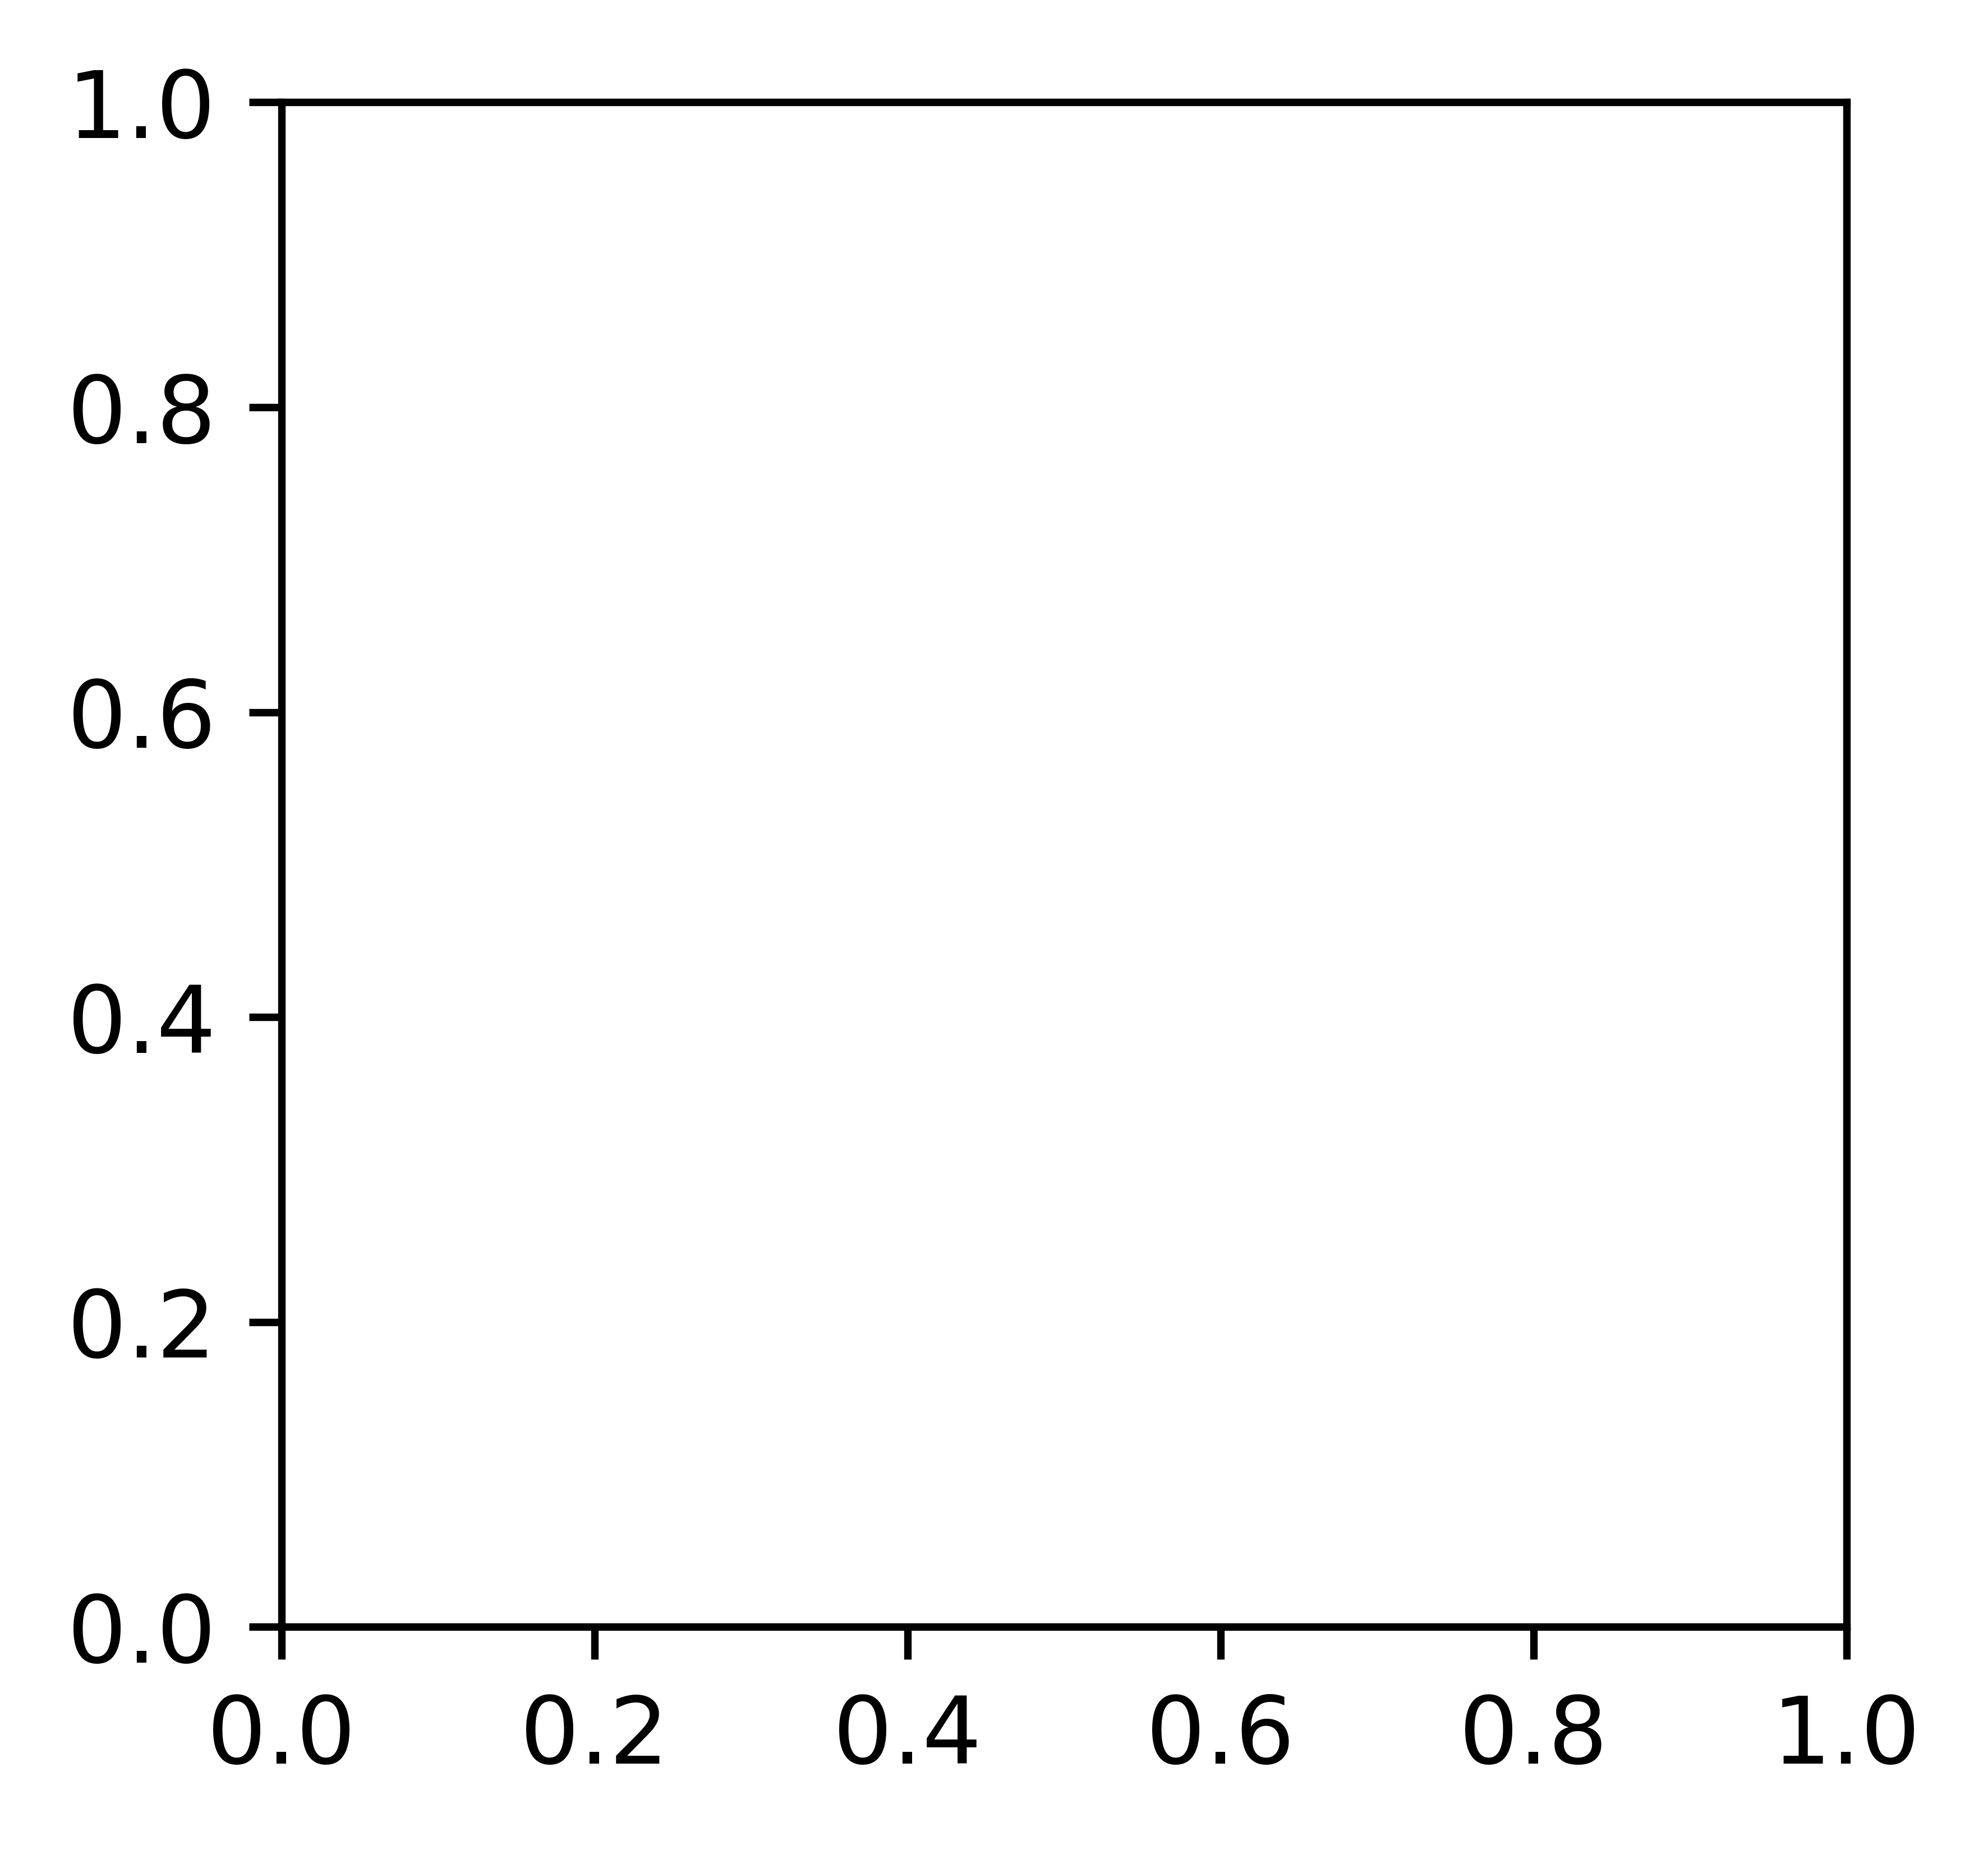

In [97]:
fig = plt.figure()
#plt.errorbar(x=control_weights, y=control_re_results, yerr=control_re_std, label="KEK = EKK", c="k")
#plt.errorbar(x=test_weights, y=test_re_results, yerr=test_re_std, label="KEK Constant", c="r")

plt.plot(x=control_weights, y=control_re_results, label="KEK = EKK", c="k")
plt.plot(x=test_weights, y=test_re_results, label="KEK Constant", c="r")


plt.xlabel("T/I Ratio")
plt.ylabel("$<R_e^2> (\sigma^2)$")
plt.title(f"Re Comparison", fontsize=8)
plt.legend()

# Single-chain comparison:

In [19]:
project = signac.get_project("../coarse-grain-sims/test-ekk-hypoth/single-chain-pl-rg-re/polybinder-flow/")

In [20]:
fig = plt.figure()
for job in project.find_jobs({"kek_weight": 1.0, "kT_quench": 4.0}):
    print(job.id, job.sp.ekk_weight)
    

880ec4b894e48f44940f1e85970bd033 0.8
9eb36517f9badcf33a59eea2717daf39 1.0
b7f3bc2d09b401f08fc19618dae38ce4 0.7
6fe1ad114706cd10db8fbc0add7aa862 0.6


<Figure size 3600x3600 with 0 Axes>

In [21]:
n_frames = 700
lp_window_size = 100
temp = 4.0

In [22]:
test_temps = []
weights = []

test_lp_results = []
test_lp_std = []
test_rg_results = []
test_rg_std = []
test_re_results = []
test_re_std = []

for weight in [0.6, 0.7, 0.8, 1.0]:
    for job in project.find_jobs({"kek_weight": 1.0, "ekk_weight": weight, "kT_quench": temp}):
        weights.append(job.sp.ekk_weight)
        with gsd.hoomd.open(job.fn("sim_traj.gsd"), "rb") as traj:
            lp_stop = len(traj)
            lp_start = lp_stop - n_frames

        lp, lp_std = persistence_length(
            gsd_file=job.fn("sim_traj.gsd"),
            start=lp_start,
            stop=lp_stop,
            window_size=lp_window_size,
            select_atoms_arg="name E K"
        )
        test_lp_results.append(lp)
        test_lp_std.append(lp_std)

        # Radius of Gyration:
        rg = radius_of_gyration(job.fn("sim_traj.gsd"), n_frames=n_frames)
        test_rg_results.append(np.mean(rg))
        test_rg_std.append(np.std(rg))

        # End-to-End Distance:
        re = end_to_end(job.fn("sim_traj.gsd"), n_frames=n_frames)
        test_re_results.append(np.mean(re))
        test_re_std.append(np.std(re))

/home/chris/miniconda3/envs/msibi/lib/python3.9/site-packages/MDAnalysis/analysis/base.py:438: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time


In [23]:
control_temps = []

control_lp_results = []
control_lp_std = []
control_rg_results = []
control_rg_std = []
control_re_results = []
control_re_std = []

for weight in weights:
    for job in project.find_jobs({"kek_weight": weight, "ekk_weight": weight, "kT_quench": temp}):
        with gsd.hoomd.open(job.fn("sim_traj.gsd"), "rb") as traj:
            lp_stop = len(traj)
            lp_start = lp_stop - n_frames

        lp, lp_std = persistence_length(
            gsd_file=job.fn("sim_traj.gsd"),
            start=lp_start,
            stop=lp_stop,
            window_size=lp_window_size,
            select_atoms_arg="name E K"
        )
        control_lp_results.append(lp)
        control_lp_std.append(lp_std)

        # Radius of Gyration:
        rg = radius_of_gyration(job.fn("sim_traj.gsd"), n_frames=n_frames)
        control_rg_results.append(np.mean(rg))
        control_rg_std.append(np.std(rg))

        # End-to-End Distance:
        re = end_to_end(job.fn("sim_traj.gsd"), n_frames=n_frames)
        control_re_results.append(np.mean(re))
        control_re_std.append(np.std(re))

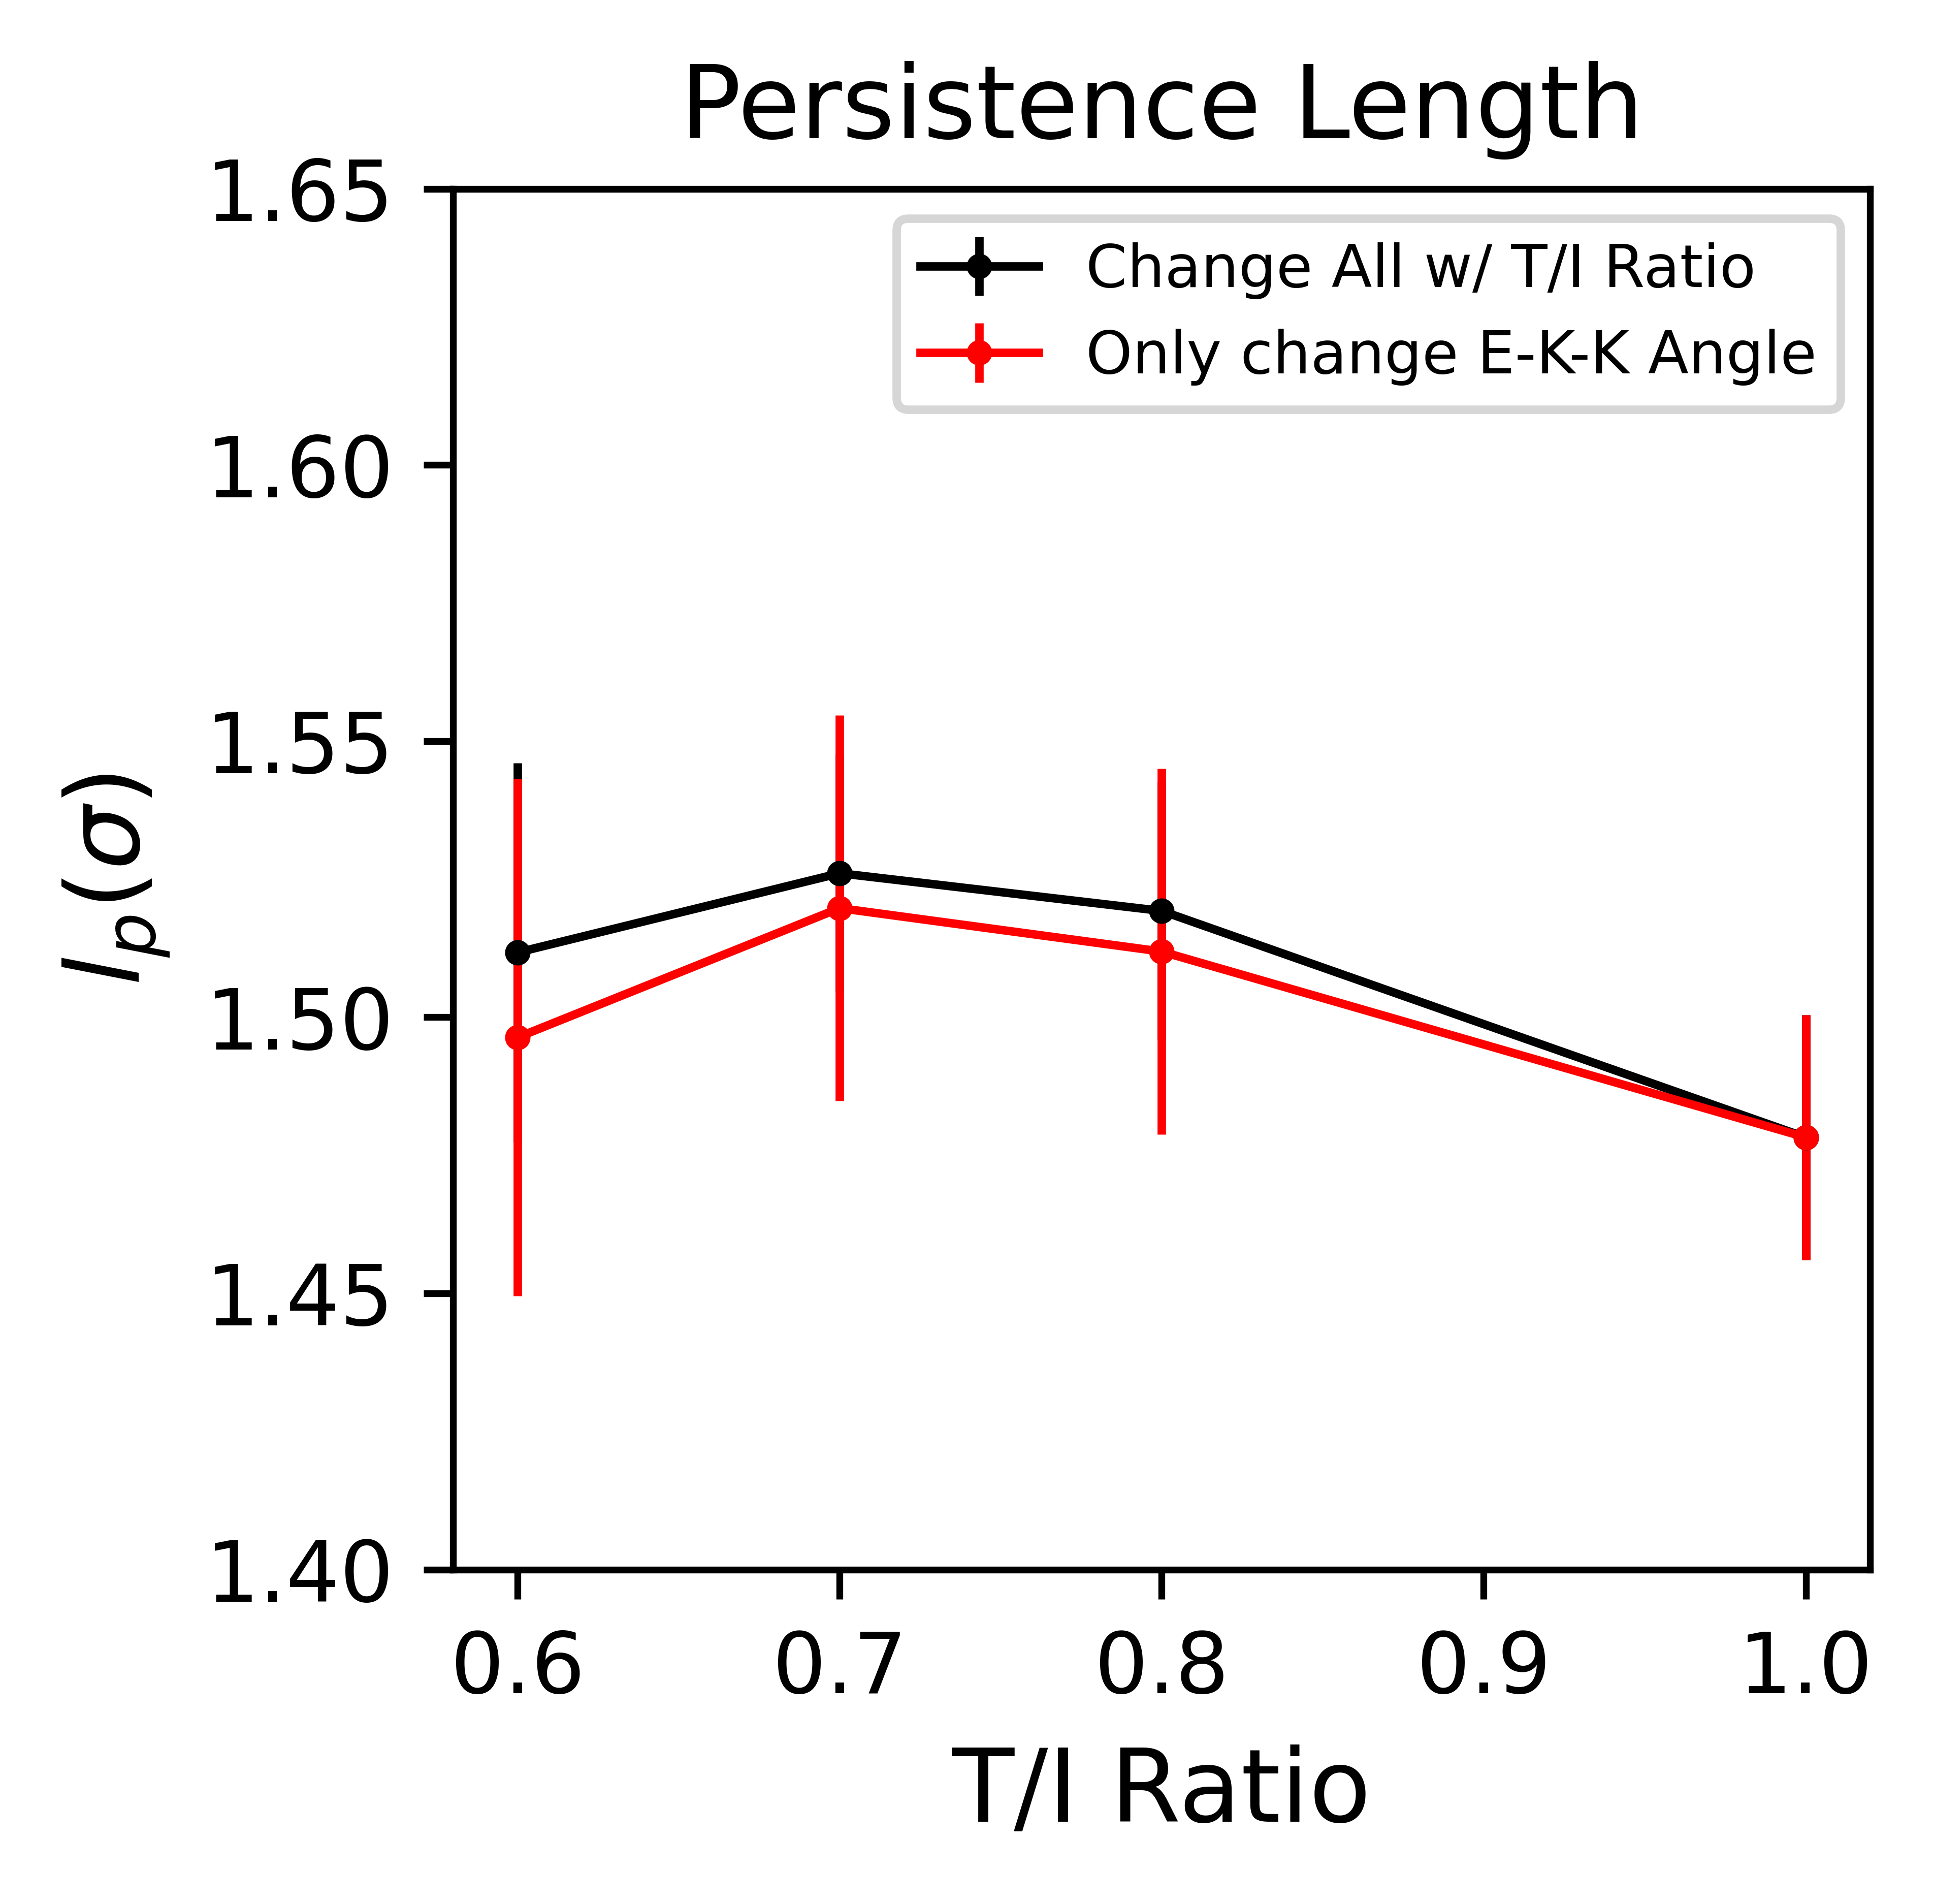

In [32]:
fig = plt.figure()
plt.errorbar(x=weights, y=control_lp_results, yerr=control_lp_std, label="Change All w/ T/I Ratio", c="k")
plt.errorbar(x=weights, y=test_lp_results, yerr=test_lp_std, label="Only change E-K-K Angle", c="r")
plt.legend()
plt.title("Persistence Length")
plt.xlabel("T/I Ratio")
plt.ylabel("$l_p (\sigma)$")
plt.ylim(1.40, 1.65)
plt.show()

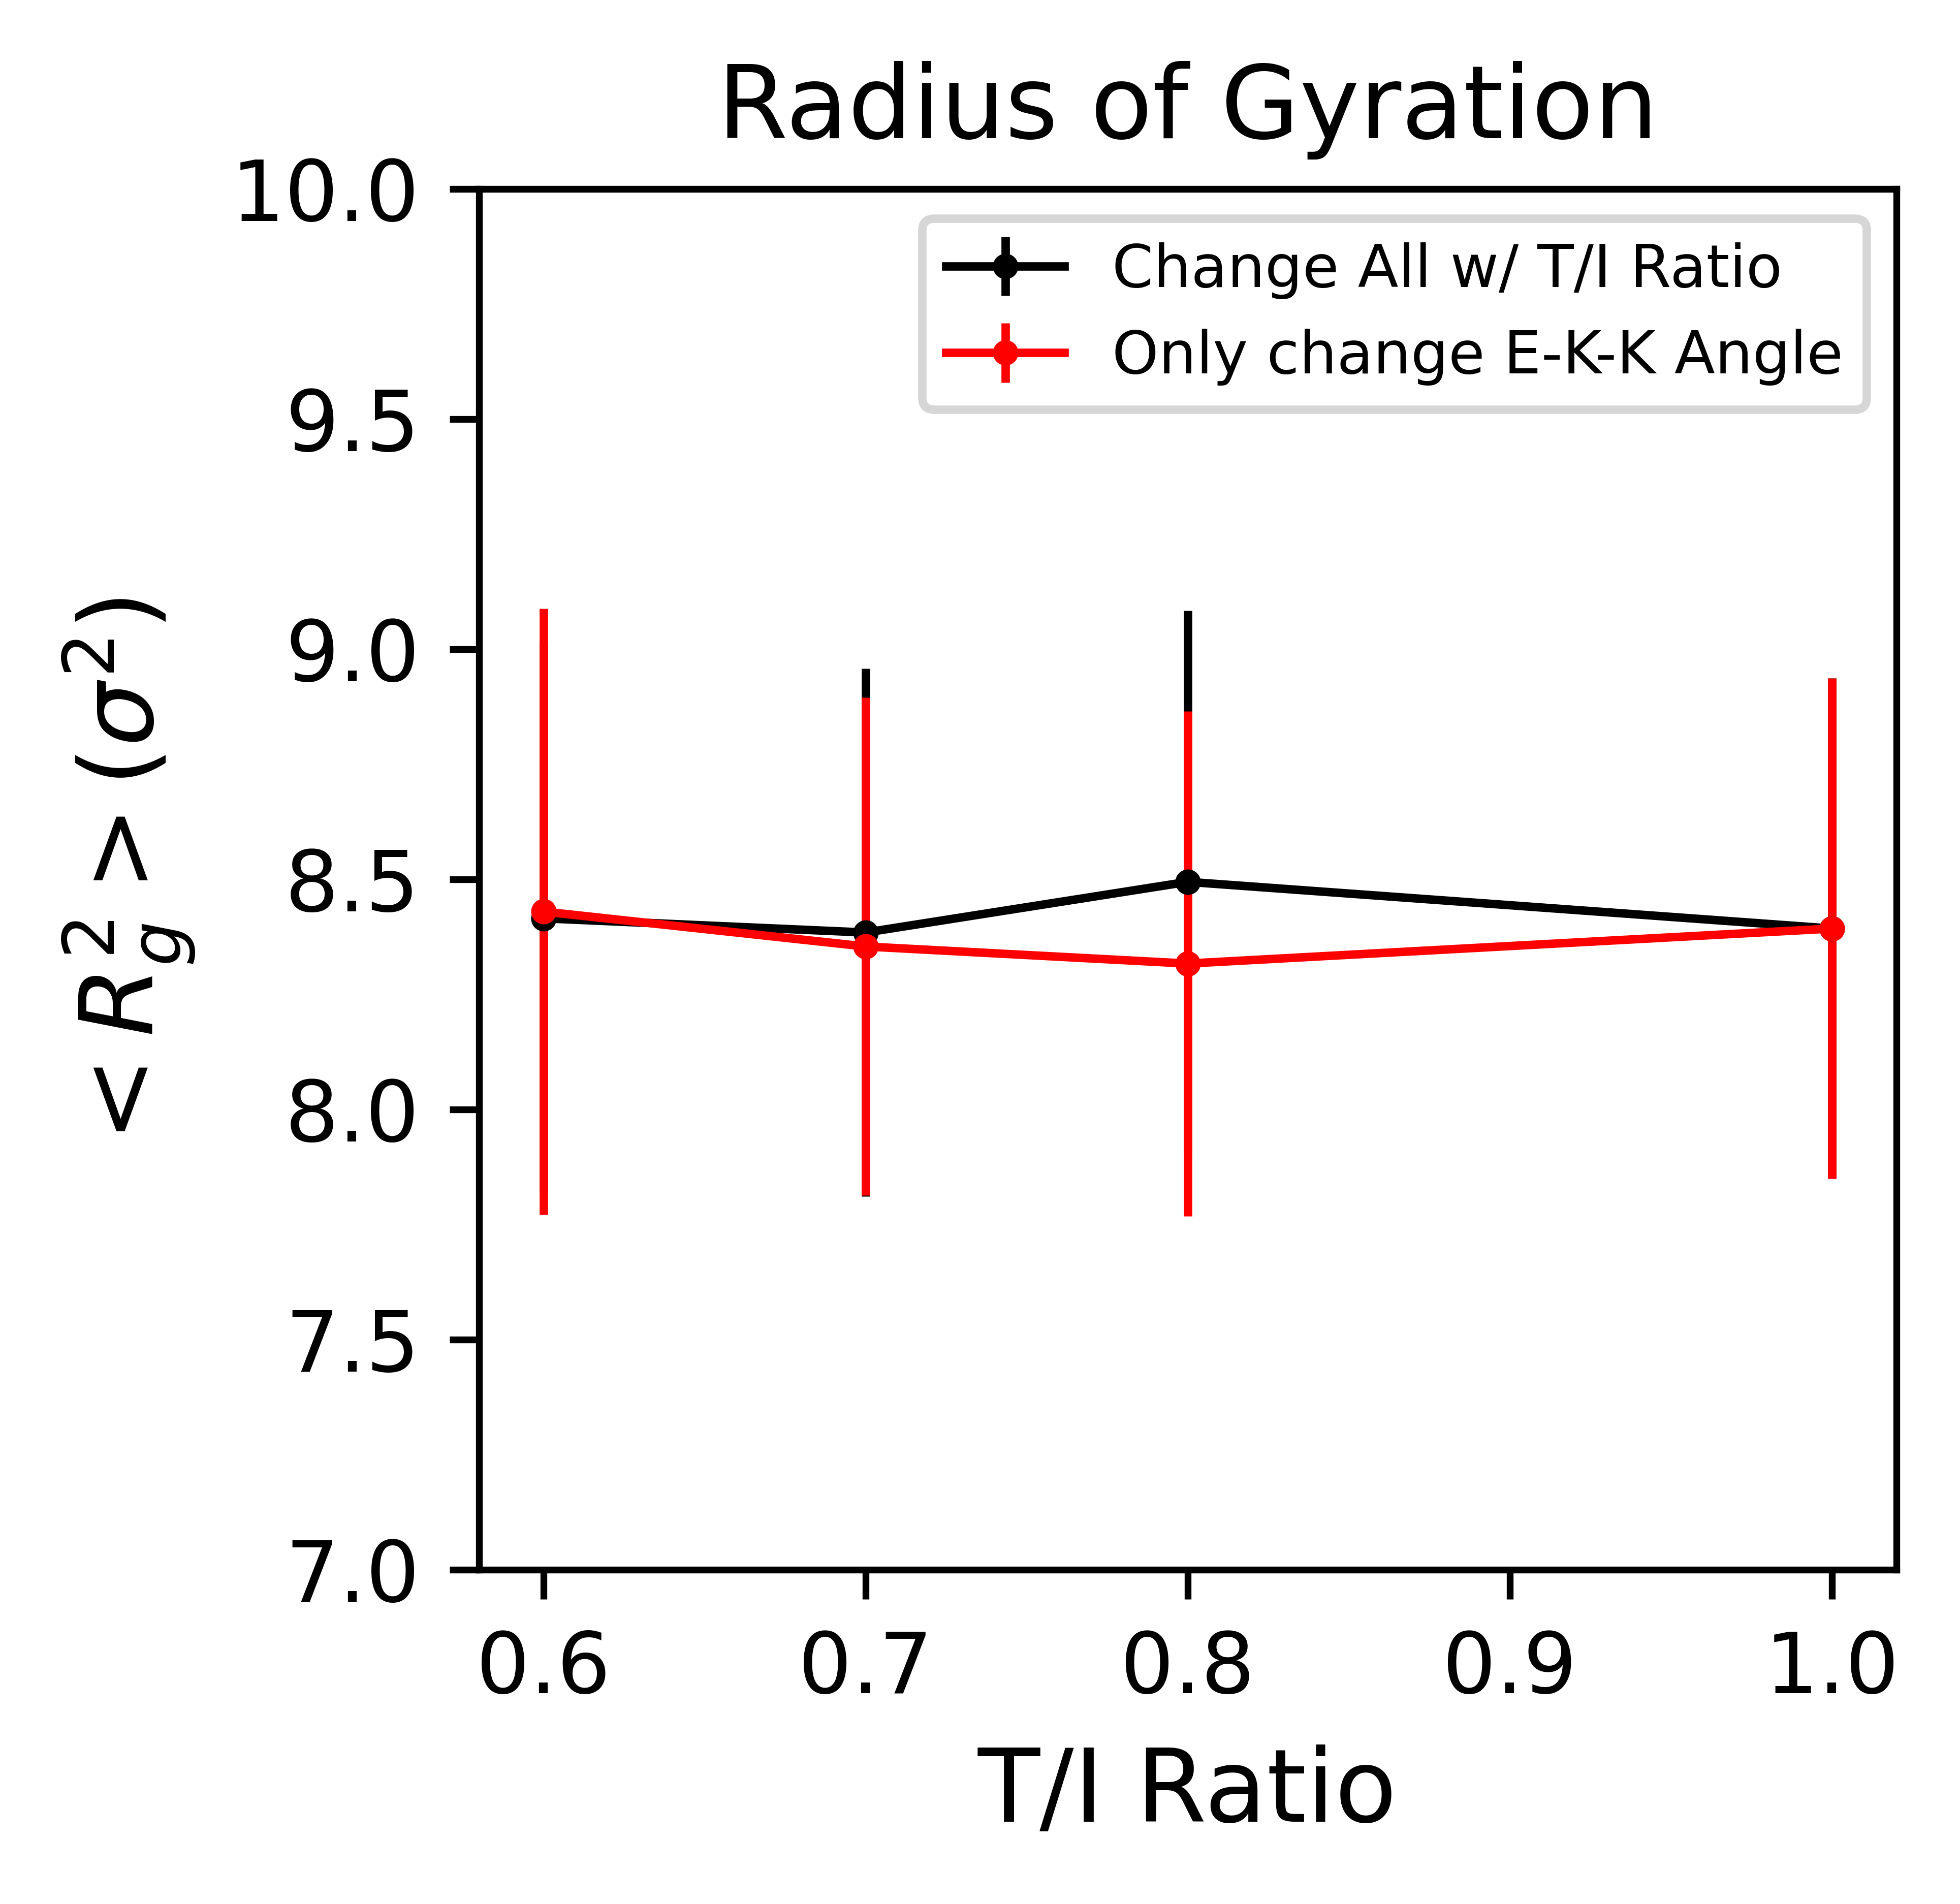

In [31]:
fig = plt.figure()
plt.errorbar(x=weights, y=control_rg_results, yerr=control_rg_std, label="Change All w/ T/I Ratio", c="k")
plt.errorbar(x=weights, y=test_rg_results, yerr=test_rg_std, label="Only change E-K-K Angle", c="r")
plt.xlabel("T/I Ratio")
plt.ylabel("$<R_g^2> (\sigma^2)$")
plt.title(f"Radius of Gyration")
plt.ylim(7, 10)
plt.legend()

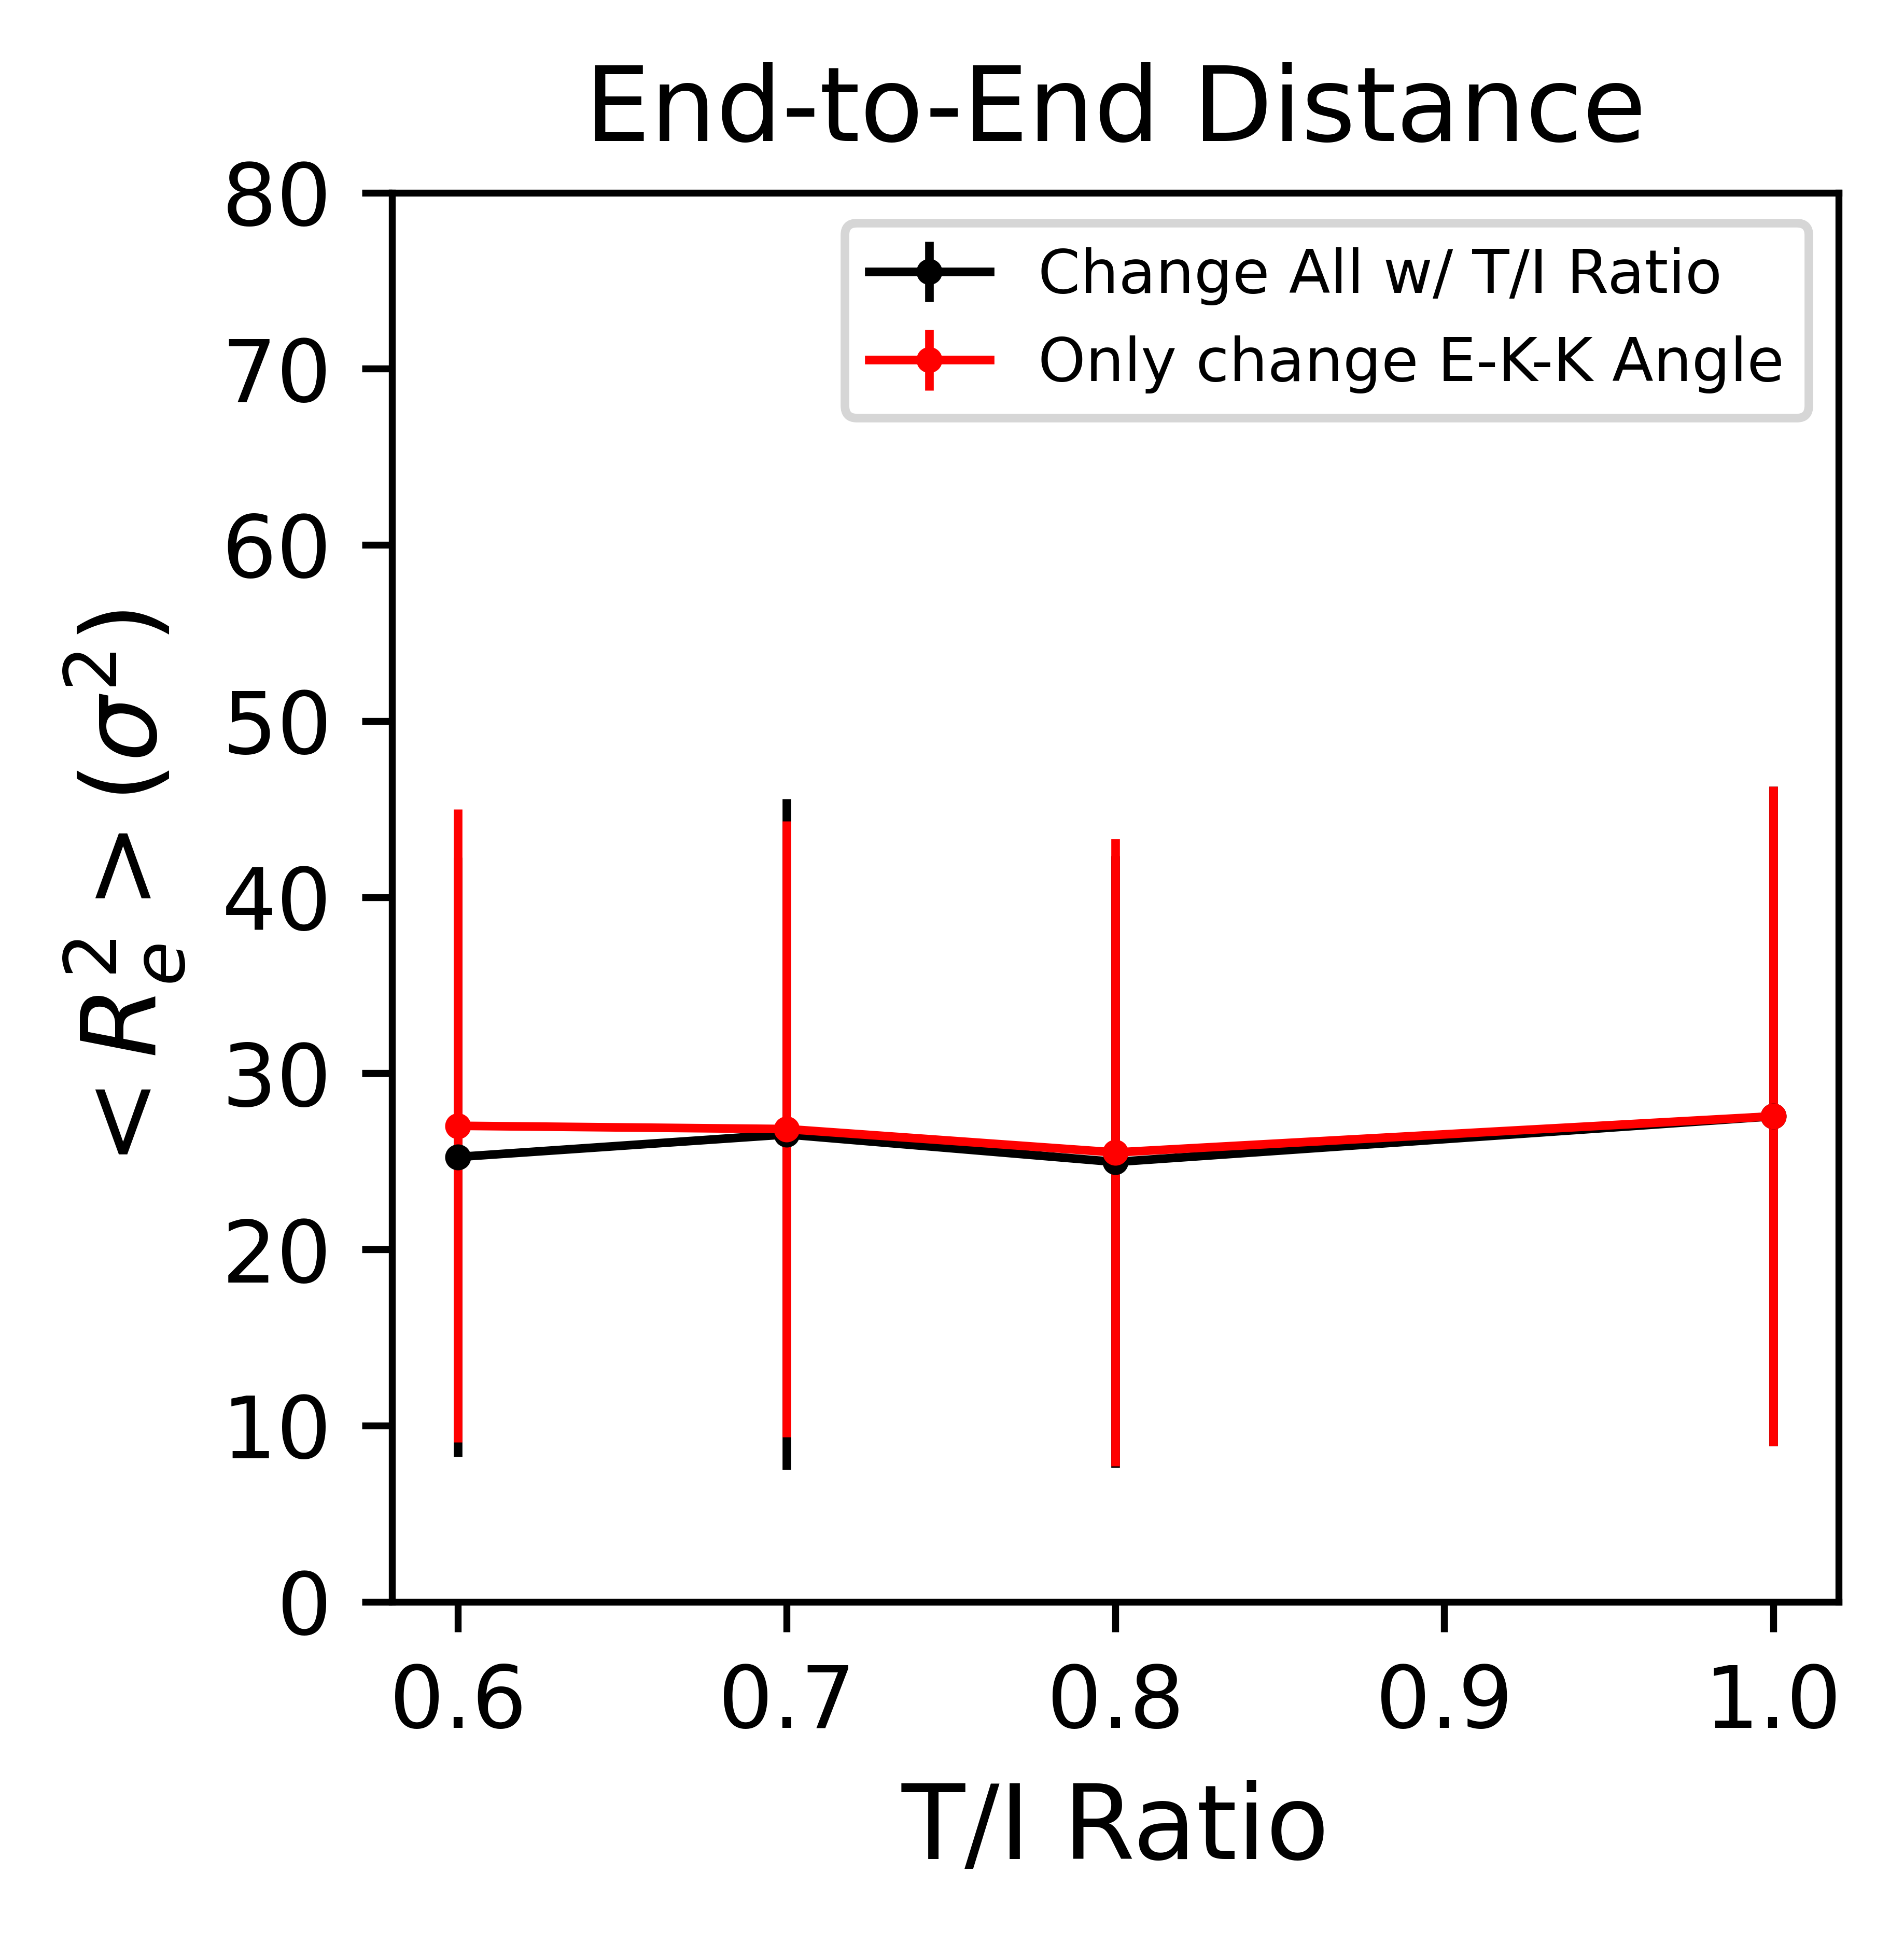

In [30]:
fig = plt.figure()
plt.errorbar(x=weights, y=control_re_results, yerr=control_re_std, label="Change All w/ T/I Ratio", c="k")
plt.errorbar(x=weights, y=test_re_results, yerr=test_re_std, label="Only change E-K-K Angle", c="r")
plt.xlabel("T/I Ratio")
plt.ylabel("$<R_e^2> (\sigma^2)$")
plt.title(f"End-to-End Distance")
plt.ylim(0, 80)
plt.legend()